In [162]:
import json
from hf_utils import get_splits, get_stats, get_size_stats, search
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import pandas as pd
from tqdm.notebook import tqdm

load_dotenv()
sns.set_theme()

## Data splits

In [4]:
splits = get_splits()

In [14]:
df_split = pd.DataFrame(splits['splits'])
df_split.sample(7)

,dataset,config,split
34,HuggingFaceFW/fineweb,CC-MAIN-2017-22,train
29,HuggingFaceFW/fineweb,CC-MAIN-2016-50,train
16,HuggingFaceFW/fineweb,CC-MAIN-2015-27,train
56,HuggingFaceFW/fineweb,CC-MAIN-2019-13,train
87,HuggingFaceFW/fineweb,CC-MAIN-2022-33,train
77,HuggingFaceFW/fineweb,CC-MAIN-2021-17,train
94,HuggingFaceFW/fineweb,CC-MAIN-2023-50,train


In [11]:
df_split.config.nunique()

96

## Size statistics

> The dataset viewer provides a `/statistics` endpoint for fetching some basic statistics precomputed for a requested dataset. This will get you a quick insight on how the data is distributed.

In [70]:
res = get_size_stats()

In [71]:
res.keys()

dict_keys(['size', 'pending', 'failed', 'partial'])

In [72]:
print(json.dumps(res, indent=4))

{
    "size": {
        "dataset": {
            "dataset": "HuggingFaceFW/fineweb",
            "num_bytes_original_files": 44968561341369,
            "num_bytes_parquet_files": 44968561341369,
            "num_bytes_memory": 80272517552332,
            "num_rows": 22335106879
        },
        "configs": [
            {
                "dataset": "HuggingFaceFW/fineweb",
                "config": "CC-MAIN-2013-20",
                "num_bytes_original_files": 422996258185,
                "num_bytes_parquet_files": 422996258185,
                "num_bytes_memory": 784077782405,
                "num_rows": 215405925,
                "num_columns": 9
            },
            {
                "dataset": "HuggingFaceFW/fineweb",
                "config": "CC-MAIN-2013-48",
                "num_bytes_original_files": 426088942450,
                "num_bytes_parquet_files": 426088942450,
                "num_bytes_memory": 800948173577,
                "num_rows": 220467287,
          

In [73]:
display(Markdown(f"""
**{round(res['size']['dataset']['num_bytes_parquet_files']/(1024**3), 3):,}** GiB
<br>
**{res['size']['dataset']['num_rows']:,}** rows
"""))


**41,880.236** GiB
<br>
**22,335,106,879** rows


In [74]:
df = pd.DataFrame(res['size']['configs'])

In [75]:
df.describe()

,num_bytes_original_files,num_bytes_parquet_files,num_bytes_memory,num_rows,num_columns
count,9.500000e+01,9.500000e+01,9.500000e+01,9.500000e+01,95.0
mean,4.733533e+11,4.733533e+11,8.449739e+11,2.351064e+08,9.0
std,8.543134e+10,8.543134e+10,1.647791e+11,4.262735e+07,0.0
min,2.754380e+11,2.754380e+11,4.772803e+11,1.315320e+08,9.0
25%,4.158639e+11,4.158639e+11,7.457545e+11,2.054806e+08,9.0
50%,4.647040e+11,4.647040e+11,8.222143e+11,2.280161e+08,9.0
75%,5.270434e+11,5.270434e+11,9.233581e+11,2.662878e+08,9.0
max,6.979284e+11,6.979284e+11,1.315635e+12,3.250136e+08,9.0


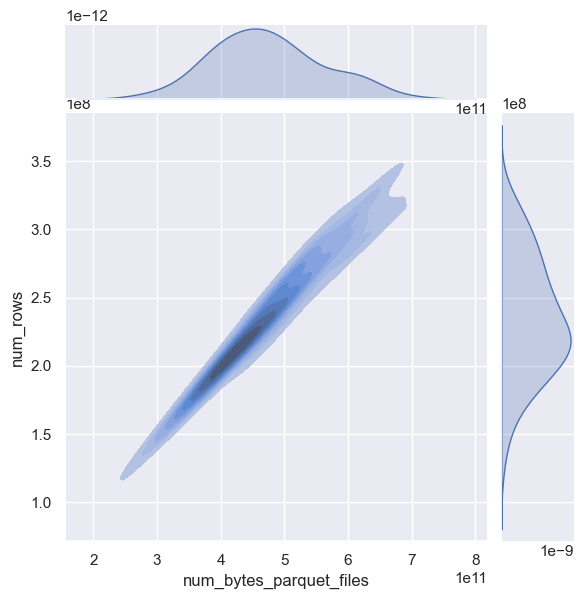

In [76]:
# sns.kdeplot(data=df, x="num_bytes_parquet_files", y='num_rows', levels=5);
sns.jointplot(data=df, x="num_bytes_parquet_files", y='num_rows', kind='kde', fill=True);

## Stats

In [18]:
dump_name=df_split.config.sample(1).values[0]
res = get_stats(dump_name)

In [25]:
stats_df = pd.DataFrame(res['statistics'])
num_examples = res['num_examples']

In [43]:
df = pd.DataFrame()
for dump_name in df_split.config:
    try:
        res = get_stats(dump_name)
        _df = pd.DataFrame(res['statistics'])
        _df['dump_name'] = dump_name
        _df['num_examples'] = res['num_examples']
        df = pd.concat([df, _df])
    except Exception as e:
        print(dump_name, e)
        continue

cols = list(df.column_statistics.values[0].keys())
for col in cols:
    df[col] = df.column_statistics.apply(lambda x: x[col] if col in x else None)
df.drop(columns=['column_statistics'], inplace=True)

default 'statistics'
CC-MAIN-2016-07 'statistics'


In [42]:
res

{'error': 'Job manager crashed while running this job (missing heartbeats).'}

In [44]:
df.sample(10)

,column_name,column_type,dump_name,num_examples,nan_count,nan_proportion,min,max,mean,median,std,histogram
8,url,string_text,CC-MAIN-2017-30,2181000,0,0.0,13.0,2449.0,72.05818,69.0,27.27498,"{'hist': [2179971, 972, 42, 4, 7, 0, 2, 0, 1, ..."
3,id,string_text,CC-MAIN-2018-51,2147000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2147000], 'bin_edges': [47, 47]}"
0,date,string_text,CC-MAIN-2015-27,2152000,0,0.0,20.0,20.0,20.00000,20.0,0.00000,"{'hist': [2152000], 'bin_edges': [20, 20]}"
4,language,string_label,CC-MAIN-2015-18,2159000,0,0.0,NaN,NaN,NaN,NaN,NaN,None
8,url,string_text,CC-MAIN-2020-40,2133000,0,0.0,14.0,3298.0,73.77092,69.0,34.97044,"{'hist': [2130773, 1749, 317, 98, 27, 15, 15, ..."
3,id,string_text,CC-MAIN-2021-49,2151000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2151000], 'bin_edges': [47, 47]}"
1,dump,string_label,CC-MAIN-2019-18,2100000,0,0.0,NaN,NaN,NaN,NaN,NaN,None
6,text,string_text,CC-MAIN-2019-30,2111000,0,0.0,83.0,668702.0,3084.72350,1875.0,5488.24807,"{'hist': [2109299, 1357, 203, 73, 27, 13, 15, ..."
6,text,string_text,CC-MAIN-2014-42,2125000,0,0.0,89.0,554519.0,3057.75926,1693.0,6697.23032,"{'hist': [2120530, 3434, 601, 220, 87, 38, 34,..."
3,id,string_text,CC-MAIN-2020-10,2111000,0,0.0,47.0,47.0,47.00000,47.0,0.00000,"{'hist': [2111000], 'bin_edges': [47, 47]}"


In [48]:
text_stats = df[df.column_name == 'text']

In [54]:
# weighted min, max, mean, std based on number_examples
row_count = text_stats.num_examples.sum()
min = 0; max = 0; mean = 0; std = 0
for idx, row in text_stats.iterrows():
    min += row['min'] * row.num_examples
    max += row['max'] * row.num_examples
    mean += row['mean'] * row.num_examples
    std += row['std'] * row.num_examples
min = min / row_count
max = max / row_count
mean = mean / row_count
std = std / row_count

In [77]:
display(Markdown(f"""
## Text column stats about character length
#### **min**: {min:.2f} 
#### **max**: {max:.2f} 
#### **mean ± std**: {mean:.2f} ± {std:.2f}
"""))


## Text column stats about character length
#### **min**: 99.19 
#### **max**: 611384.95 
#### **mean ± std**: 3053.66 ± 6048.17


## Does the crawl reference my `keyword`?

In [115]:
keyword = 'Metaflow'

In [143]:
splits_after_2023 = []
for split in splits['splits']:
    if split['config'].startswith('CC-MAIN-2023') or split['config'].startswith('CC-MAIN-2024'):
        splits_after_2023.append(split['config'])

In [144]:
len(splits_after_2023)

6

In [150]:
splits_after_2023

['CC-MAIN-2023-06',
 'CC-MAIN-2023-14',
 'CC-MAIN-2023-23',
 'CC-MAIN-2023-40',
 'CC-MAIN-2023-50',
 'CC-MAIN-2024-10']

In [158]:
ref = search(splits_after_2023[0], query=keyword)

In [166]:
def fetch_all_references(keyword, splits):
    mentions = []
    for split in tqdm(splits):
        res = search(split, query=keyword)
        try:
            for row in res['rows']:
                mentions.append(row['row'])
        except KeyError:
            print(split)
    return mentions

In [167]:
mentions = fetch_all_references(keyword, splits_after_2023)

  0%|          | 0/6 [00:00<?, ?it/s]

In [168]:
for m in mentions:
    display(Markdown(f"""
### {m['dump']}
### {m['url']}
    """))
    display(Markdown(m['text'].replace("Metaflow", '<span style="background-color: yellow">Metaflow</span>')))
    display(Markdown('---'))


### CC-MAIN-2023-06
### https://morioh.com/p/aed7b9e1b7a3
    

Prophet: Automatic Forecasting Procedure
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
Prophet is a CRAN package so you can use
After installation, you can get started!
You can also choose an experimental alternative stan backend called
cmdstanr. Once you've installed
prophet, follow these instructions to use
cmdstanr instead of
rstan as the backend:
# R # We recommend running this is a fresh R session or restarting your current session install.packages(c("cmdstanr", "posterior"), repos = c("https://mc-stan.org/r-packages/", getOption("repos"))) # If you haven't installed cmdstan before, run: cmdstanr::install_cmdstan() # Otherwise, you can point cmdstanr to your cmdstan path: cmdstanr::set_cmdstan_path(path = <your existing cmdstan>) # Set the R_STAN_BACKEND environment variable Sys.setenv(R_STAN_BACKEND = "CMDSTANR")
If you have custom Stan compiler settings, install from source rather than the CRAN binary.
Prophet is on PyPI, so you can use
pip to install it. From v0.6 onwards, Python 2 is no longer supported. As of v1.0, the package name on PyPI is "prophet"; prior to v1.0 it was "fbprophet".
# Install pystan with pip before using pip to install prophet # pystan>=3.0 is currently not supported pip install pystan==188.8.131.52 pip install prophet
The default dependency that Prophet has is
pystan. PyStan has its own installation instructions. Install pystan with pip before using pip to install prophet.
You can also choose a (more experimental) alternative stan backend called
cmdstanpy. It requires the CmdStan command line interface and you will have to specify the environment variable
STAN_BACKEND pointing to it, for example:
# bash $ CMDSTAN=/tmp/cmdstan-2.22.1 STAN_BACKEND=CMDSTANPY pip install prophet
Note that the
CMDSTAN variable is directly related to
cmdstanpy module and can be omitted if your CmdStan binaries are in your
It is also possible to install Prophet with two backends:
# bash $ CMDSTAN=/tmp/cmdstan-2.22.1 STAN_BACKEND=PYSTAN,CMDSTANPY pip install prophet
After installation, you can get started!
If you upgrade the version of PyStan installed on your system, you may need to reinstall prophet (see here).
conda install gcc to set up gcc. The easiest way to install Prophet is through conda-forge:
conda install -c conda-forge prophet.
On Windows, PyStan requires a compiler so you'll need to follow the instructions. The easiest way to install Prophet in Windows is in Anaconda.
Make sure compilers (gcc, g++, build-essential) and Python development tools (python-dev, python3-dev) are installed. In Red Hat systems, install the packages gcc64 and gcc64-c++. If you are using a VM, be aware that you will need at least 4GB of memory to install prophet, and at least 2GB of memory to use prophet.
cmdstanpybackend now available in Python
Predicting stock prices is a difficult task. Several factors can affect the price of the stock which is not always easy to accommodate in a model. There is no model in the world currently which can accurately predict the stock prices and there might never be one owing to the reasons mentioned above. Facebook has given a “state of the art model” and “easy to use” and a wide range of hyperparameter tuning options to give somewhat accurate predictions.
As mentioned above, we have a dataset that has stock prices for New Germany Fund from the year 2013 to 2018. Now as we import the data and see it for the first time, we see that it is not sorted in the ascending order of the dates, This is a major issue as forecasted values are more likely to depend on the immediate past entries rather than entries before.
stock_prices['DATE'] = pd.to_datetime(stock_prices["DATE"]) stock_prices = stock_prices.sort_values(by="DATE")
After this, we plot the values of the opening price by date.
As you can see there is a sudden drop in values from 2013 to 2014 which is very unusual. A possible reason for this is that there may be very few values for the year 2013. We check that using the following code.
stock_prices = stock_prices[stock_prices.Year == 2013]
The above code results in a dataset with only 3 entries. We remove these values.
stock_prices = stock_prices[stock_prices.Year != 2013]
The data finally looks like:
We also need to set the index of our dataset as the date, but we can’t access the date as it is now a Dataframe index. To resolve this issue, we will first create a copy of the Date column.
stock_prices[‘date’] = stock_prices[‘DATE’] stock_prices.set_index("DATE", inplace = True)
The autocorrelation gives us insight into the seasonality of the model. In case the correlation value is high for a certain number of lags, that lag number is the seasonality.
Lag of value one corresponds to one day as the time step in our dataset is a day.
Evident from the below plot, the correlation is high for lags close to 0. The value of autocorrelation seems to decrease for a higher value of lags. Implying that as such, there is no seasonality within our data.
Autocorrelation vs Lags
We further gain insight into the yearly growth in data. The year 2017 has the largest area, hence the most growth.
Growth vs Years
#time-series-forecasting #prophet #stock-prediction #forecasting #machine-learning #deep learning
This tutorial was created to democratize data science for business users (i.e., minimize usage of advanced mathematics topics) and alleviate personal frustration we have experienced on following tutorials and struggling to apply that same tutorial for our needs. Considering this, our mission is as follows:
#python #data-science #machine-learning-ai #forecasting #prophet
Forecasting future demand is a fundamental business problem and any solution that is successful in tackling this will find valuable commercial applications in diverse business segments. In the retail context, Demand Forecasting methods are implemented to make decisions regarding buying, provisioning, replenishment, and financial planning. Some of the common time-series methods applied for Demand Forecasting and provisioning include Moving Average, Exponential Smoothing, and ARIMA. The most popular models in Kaggle competitions for time-series forecasting have been Gradient Boosting models that convert time-series data into tabular data, with lag terms in the time-series as ‘features’ or columns in the table.
The Facebook Prophet model is a type of GAM (Generalized Additive Model) that specializes in solving business/econometric — time-series problems. My objective in this project was to apply and investigate the performance of the Facebook Prophet model for Demand Forecasting problems and to this end, I used the Kaggle M5- Demand Forecasting Competition Dataset and participated in the competition. The competition aimed to generate point forecasts 28 days ahead at a product- store level.
The dataset involves unit sales of 3049 products and is classified into 3 product categories (Hobbies, Foods, and Household) and 7 departments. The products are sold in 10 stores located across 3 states (CA, TX, and WI). The diagram gives an overview of the levels of aggregations of the products. The competition data has been made available by Walmart.
Fig 1: Breakdown of the time-series Hierarchy and Aggregation Level 
Fig 2: Data Hierarchy Diagram 
The data range for Sales Data is from 2011–01–29 to 2016–06–19. Thus products have a maximum of 1941 days or 5.4 years worth of available data. (The Test dataset of 28 days is not included).
The datasets are divided into Calendar Data, Price Data, and Sales Data .
**Calendar Data — **contains columns, like date, weekday, month, year, and Snap-Days for the states TX, CA, and WI. Additionally, the table contains information on holidays and special events (like Superbowl) through its columns event_type1 and event_type2. The holidays/ special events are divided into cultural, national, religious, and sporting .
Price Data- The table consists of the columns — store, item, week, and price. It provides information on the price of an item at a particular store, in a particular week .
Sales Data — consists of validation and evaluation files. The evaluation file consists of sales for 28 extra days which can be used for model evaluation. The table provides information on the quantity sold for a particular item in a particular department, in a particular state, and store .
The data can be found in the link
Fig 3: Sales Qty.in Each State
Fig 4: Sales % in Each category
Fig 5: Sales % in Each State
As can be seen from the charts above, for every category, the highest number of sales occur in CA, followed by TX and WI. CA contributes to around 50% of Hobby sales. The sales distribution across categories in the three states is symmetric and the highest-selling categories ordered by descending order of sales in each state are Foods, Household, and Hobbies.
#time-series-forecasting #prophet #time-series-analysis #data-science #demand-for-evidence #data analysis
As part of an anomaly detection project, I have recently been able to use two very interesting open source products: Prophet released by the Core Data Science team by Facebook and <span style="background-color: yellow">Metaflow</span>, an excellent framework by Netflix. I used Prophet, in a <span style="background-color: yellow">Metaflow</span> flow, to create forecast models of time series. I decided to write this post to share my experience with these two products, creating a small machine learning project.
Being able to predict the future trend of a time series is very useful in many applications, from the world of finance to sales. For example, we try to predict the direction of the stock market or the correct supply of resources. This post does not set such ambitious goals, but only wants to explore the possibilities offered by Prophet by creating a forecast model that determines the future trend of daily temperatures. To train the model, I used a dataset that collects the minimum daily temperatures over 10 years (1981–1990) in the city of Melbourne, Australia. The source of the data is the Australian Bureau of Meteorology.
The entire source code of the project is available in this git repository
Let’s analyze our dataset with a simple notebook. We use Python and Pandas to load the CSV file.
#aws-batch #metaflow #time-series-forecasting #prophet #aws
I used to use Rob J Hyndman’s
[fpp2](https://cran.r-project.org/web/packages/fpp2/index.html) forecasting package. Quite a lot. Still it’s my go-to forecasting library. The reason I like it so much is that it comes with extensive coverage of forecasting techniques and an invaluable open access book that has all the theories going into forecasting. Pretty much everything you need for academic research on time series is there.
But that’s also the downside of the package, it’s not beginner-friendly. Who wants to build a car just to drive it on the road?
Then Facebook Prophet came along.
Prophet made unbelievable simplification to forecasting exercise. You can use it out of the box without needing to understand a lot of theories, as you are about to see below.
The package is very intuitive to use and is especially powerful for business forecasting. You can even specify weekends, special days and events (e.g. Superbowl) that impact business activities.
Cherry on top, Prophet is available in both python and R programming language!
Let’s do a quick demo.
I’m doing it in Python, so all you need is
pandas package for manipulating data.
And of course
## improt libraries import pandas as pd from fbprophet import Prophet
The dataset I’m going to use is a time series consisting of daily minimum temperature recorded for 10 years between 1981 and 1990.
## import data df = pd.read_csv("https://bit.ly/3hJwIm0") ## check out first few rows df.head()
As you can see, the datarame has just two columns, one on the time dimension and the other on observations.
Some data formatting is needed.
Prophet requires that the datetime column is named as “ds” and the observation column as “y”.
#time-series-analysis #data-science #machine-learning #facebook-prophet #forecasting

---


### CC-MAIN-2023-06
### https://ftic.net/tag/metamansions/
    

What is the Metaverse? The Metaverse is the next version of the internet. Interest in metaverses skyrocketed when Mark Zuckerberg announced Facebook is changing its name to Meta, and spending $10 billion developing its own metaverse. We have gone from desktops to laptops, tablets to cellphones, and now to VR headsets and glasses. We have also evolved from texting words and emojis, to uploading photos and .gifs, streaming video, and now we can enter virtual worlds surrounding ourselves with augmented realities. The metaverse is a Tron like technology. A digital world literally built around people.
The metaverse’s allure is that it allows users to live inside a mirage, which is completely surreal. Offering an out-of-body, mind-altering false sense of being physically present inside a digitally created alternate universe – a Metaverse. In the three-dimensional (3D) metaverse, users can virtually: walk around and explore, meet other users, work, learn, shop, create, socialize, entertain, game, collaborate, team build, relax, meditate, travel, chill out, and play. In fact, until now, the most common use for the metaverse was gaming like Fortnite and Minecraft.
Property in the Metaverse. Say Beatlejuice 3x and you may summon a trickster ghost from the netherworld. But if you say, “Location, Location, Location” you may accidentally transport yourself into the three-dimensional (3D) metaverse.
In this virtual world akin to MTV’s ’“Cribs,” users can adorn VR glasses and instantaneously teleport inside a palatially immaculate, virtually decorated, dreamhome-space. Graphically design your meta-mansion in any style you like; contemporary, modern, farm, colonial, medieval, the sky is the limit. Decorate your virtual mansion with photorealistic and lifelike recreations of priceless art, designer furniture, flooring, tapestries, fireplace, landscapes, water features, and any ornamental accessory your heart desires. Set your view to overlook mountains out of one window, a cityscape out the other, and the fantasy of sunsetting ocean view elsewhere. The opportunity for embellishment and extravagance is boundless.
Put up family pictures and videos. Invite friends over from Dubai, Chicago, England, Singapore, to play games, hang out, have a business meeting, or just watch a movie.
How to Access the Metaverse? There is no single app named the Metaverse that can be opened. Unlike the internet the Metaverse (or stated more accurately, “a metaverse”) is/are not interconnected. The Metaverse is actually different digitally created universes, currently existing on only a handful of platforms, some of which you will need special VR headsets to use.
Where to Buy Property in the Metaverse? People can buy, sell, develop, and lease virtual property on platforms such as: CryptoVoxels, Decentraland, Mirandus, Sandbox, Somnium Space, and Upland. Facebook plans to launch Horizon Homes as their virtual properties, marketing them as a custom social space.
Why Buy in Property in the Metaverse? Digital real estate can serve a variety of purposes, from retail showrooms, to event spaces, homes, and virtual offices. Luxury brands such as Louis Vuitton, Gucci and Burberry have already entered the metaverse through designer NFTs.
Toronto based Tokens.com, bought an estate in Decentraland in November for 618,000 MANA, the equivalent of $2,428,740.00 (i.e. $3.58 per MANA at the time). Crypto is highly volatile, so as of the date of this article the price of MANA was down more than $1.00 since the purchase. The purchase of that property was made up of 116 smaller parcels, measuring 52.5 square feet each, making 6,090 virtual square feet in size. The space is in the “Fashion Street” area of Decentraland’s map and Tokens.com said it would be used to host digital fashion events and sell virtual clothing for avatars. That’s right, people pay real money for virtual clothes. Virtual possessions generate real sales in the “metaverse.” Decentraland also has a shopping mall called Metajuku, and the Ice Poker Casino where users can gamble.
Shortly thereafter, Republic Realm bought a plot in Sandbox for the equivalent of $4.3M using the cryptocurrency SAND, from Atari SA, marking the biggest metaverse property sale. In the last week of November 2021, $70.6 Million in sales closed 4,400 metaverse properties. Luxury realtors Tal and Oren Alexander, reported to The Real Deal that they were partnering with Republic Realm to build “architecturally significant master-planned community that will span at least three of the virtual worlds.” And what metaverse property in Sandbox would be complete without a virtual mega yacht? That’s right, the MetaFlower virtual mega yacht sold for the equivalent of $650,000.
Metaverse Group, has a significant portfolio of digital real estate, and plans to spin off its holdings as the first Metaverse REIT.
Emcee Studios announced plans to acquire a 1.2M Sq. Ft. building in L.A., intending to hire tens of thousands of creators and innovators as part of the largest metaverse hub in the world.
Miami based venture capital firm CloudTree Ventures, which assembled in late 2021, foresees the crossover of technology used in gaming as the driving future for industries within the metaverse.
Commercial Branding in the Metaverse. As mentioned earlier, shopping centers are being built inside of the metaverses. JPMorgan opened a lounge inside Decentraland. Walmart, Adidas, Nike, Gucci, Disney and Warner Music, among others, plan to develop virtual storefronts, offices, and entertainment venues.
Metaverse for schools and education. Locally, the David Posnack JCC in Davie, Florida recently did a groundbreaking on its “George Gottlieb Holocaust & Jewish Education Program.” Visitors can walk through Anne Frank and her family’s hiding place in VR, just as if they were really there in Amsterdam.
Is the Metaverse a Fad? It’s hard to tell yet whether the metaverse will bubble like the dot.coms or start an entirely whole new asset class. The global pandemic fueled interest in the metaverse. When people were sheltered in lockdown, they began looking for alternate realities. But as COVID-19 cases downswing, and public and gathering spaces become fully accessible, the need for meeting within metaverses as opposed to physically becomes less necessary. But then again, IRL (short for “In Real Life”) there is a paucity of raw land, which is a limitation the metaverse does not have. Digital land sales overall surpassed $500 million in January 2022. Younger generations are not just gaming in the metaverse, but also living in it to an extent. And if that is not enough, corporate titans like Facebook, actually changed their name to Meta, and with billions at stake, are betting heavily on the metaverse.
How do You Buy Property in the Metaverse. Land and other items in your chosen metaverse are purchased typically with cryptocurrency. Some metaverses have their own crypto currency. Decentraland are sold in the form of non-fungible tokens (NFTs), a kind of crypto asset. Crypto enthusiasts buy land there as a speculative investment, using Decentraland’s cryptocurrency, MANA.
Valuing Property in the Metaverse. Similar to an appraisal users are advised to compare values of other like kind properties, look at statistics such as monthly active-user lists, see whether the company that launched the metaverse where the property is located had prior success in the video gaming or other platforms.
Are there Real Estate Companies in the Metaverse? Metaverse Properties purports to be the first virtual real estate company, offering to help consumers: buy, sell, and even lease properties on different metaverse platforms; develop virtual properties; manage properties; consult, and market metaverse properties.
Are Real Estate License Required to Buy, Sell, or Lease “Space” in the Metaverse? Probably not. Florida Statute §475.01(1)(i) defines “‘Real property’ or ‘real estate’ as any interest or estate in land and any interest in business enterprises or business opportunities, including any assignment, leasehold, subleasehold, or mineral right; however, the term does not include any cemetery lot or right of burial in any cemetery; nor does the term include the renting of a mobile home lot or recreational vehicle lot in a mobile home park or travel park.’”
Using the Metaverse to Market “Real” Properties. To entice buyers, developers are reportedly offering to build customers both a luxury home in Miami and a twinning digital replica on the metaverse. The idea being buyers could maintain a normal life at home and then while traveling have a digital version in the metaverse to host virtual gatherings from around the world.
Photorealistic Avatars in the Metaverse. Also, it bears mentioning, that the first thing you need to do before stepping into a Metaverse is to create your own avatar. Instead of static profile pictures, people represent themselves in the Metaverse using a wardrobe of avatar skins. Currently the avatars look cartoonish. But just like shopping in real life, you can customize your outfits, sneakers, style your hair, buy wigs, wear contacts to change your eye color, and even accessorizing. Imagine digital Nikes and a Gucci Jacket. People care what their avatars are wearing reported Reuters which produced a video of various wearables, and identified a virtual kimono vendor as making around $5K a week. Avatars are digital figurines used to represent yourself physical form in a metaphysical universe. Moreover, it is likely users will have more than one avatar. Using realistic looking avatars for work, a stylized avatars for socializing with friends, and a fantasy avatars for gaming. But significant developments are in the works to make Codec Avatars. Codec Avatars are a recent class of learned, photorealistic face models that accurately represent the geometry and texture of a person in 3D (i.e., for virtual reality), and are so indistinguishable from video that security measures are also being developed to prevent identity theft.
Conclusion. The metaverse is a revolutionary evolutionary three-dimensional virtual world for social platforms and connections. An ability to instantly, and digitally, float into a utopian society, to feel physically present in your own Shangri-La, or retreat and hangout with family and friends in a shared sense of space, regardless of how far apart they really are. A fully immersive out-of-body embodiment inside the internet. Currently, the technology seems a bit weak, with floating pixelated cartoony looking avatars but there is no doubt that will soon change once Facebook delivers on its promise of photorealism.
DISCLAIMER: Topics discussed are general concepts, not intended to constitute legal advice, accuracy, nor completeness, and may not be relied upon as such; consult an attorney or accountant. The author Randy Gilbert, J.D. is neither an attorney nor an accountant. FTIC is a national award winning title insurance company known for its white glove customer service and “No Junk Fee Guarantee.” ®

---


### CC-MAIN-2023-23
### https://lmgfl.com/real-estate-in-the-metaverse/
    

Randy Gilbert, J.D.
Chief Happiness Officer
Florida’s Title Insurance Company
(954) 500-Title (8485)
What is the Metaverse? The Metaverse is the next version of the internet. Interest in metaverses skyrocketed when Mark Zuckerberg announced Facebook is changing its name to Meta, and spending $10 billion developing its own metaverse. We have gone from desktops to laptops, tablets to cellphones, and now to VR headsets and glasses. We have also evolved from texting words and emojis, to uploading photos and .gifs, streaming video, and now we can enter virtual worlds surrounding ourselves with augmented realities. The metaverse is a Tron like technology. A digital world literally built around people.
The metaverse’s allure is that it allows users to live inside a mirage, which is completely surreal. Offering an out-of-body, mind-altering false sense of being physically present inside a digitally created alternate universe – a Metaverse. In the three-dimensional (3D) metaverse, users can virtually: walk around and explore, meet other users, work, learn, shop, create, socialize, entertain, game, collaborate, team build, relax, meditate, travel, chill out, and play. In fact, until now, the most common use for the metaverse was gaming like Fortnite and Minecraft.
Property in the Metaverse. Say Beatlejuice 3x and you may summon a trickster ghost from the netherworld. But if you say, “Location, Location, Location” you may accidentally transport yourself into the three-dimensional (3D) metaverse.
In this virtual world akin to MTV’s ’“Cribs,” users can adorn VR glasses and instantaneously teleport inside a palatially immaculate, virtually decorated, dream home-space. Graphically design your meta-mansion in any style you like; contemporary, modern, farm, colonial, medieval, the sky is the limit. Decorate your virtual mansion with photorealistic and lifelike recreations of priceless art, designer furniture, flooring, tapestries, fireplace, landscapes, water features, and any ornamental accessory your heart desires. Set your view to overlook mountains out of one window, a cityscape out the other, and the fantasy of sunsetting ocean view elsewhere. The opportunity for embellishment and extravagance is boundless.
Put up family pictures and videos. Invite friends over from Dubai, Chicago, England, Singapore, to play games, hang out, have a business meeting, or just watch a movie.
How to Access the Metaverse? There is no single app named the Metaverse that can be opened. Unlike the internet the Metaverse (or stated more accurately, “a metaverse”) is/are not interconnected. The Metaverse is actually different digitally created universes, currently existing on only a handful of platforms, some of which you will need special VR headsets to use.
Where to Buy Property in the Metaverse? People can buy, sell, develop, and lease virtual property on platforms such as: CryptoVoxels, Decentraland, Mirandus, Sandbox, Somnium Space, and Upland. Facebook plans to launch Horizon Homes as their virtual properties, marketing them as a custom social space.
Why Buy in Property in the Metaverse? Digital real estate can serve a variety of purposes, from retail showrooms, to event spaces, homes, and virtual offices. Luxury brands such as Louis Vuitton, Gucci and Burberry have already entered the metaverse through designer NFTs.
Toronto based Tokens.com, bought an estate in Decentraland in November for 618,000 MANA, the equivalent of $2,428,740.00 (i.e. $3.58 per MANA at the time). Crypto is highly volatile, so as of the date of this article the price of MANA was down more than $1.00 since the purchase. The purchase of that property was made up of 116 smaller parcels, measuring 52.5 square feet each, making 6,090 virtual square feet in size. The space is in the “Fashion Street” area of Decentraland’s map and Tokens.com said it would be used to host digital fashion events and sell virtual clothing for avatars. That’s right, people pay real money for virtual clothes. Virtual possessions generate real sales in the “metaverse.” Decentraland also has a shopping mall called Metajuku, and the Ice Poker Casino where users can gamble.
Shortly thereafter, Republic Realm bought a plot in Sandbox for the equivalent of $4.3M using the cryptocurrency SAND, from Atari SA, marking the biggest metaverse property sale. In the last week of November 2021, $70.6 Million in sales closed 4,400 metaverse properties. Luxury realtors Tal and Oren Alexander, reported to The Real Deal that they were partnering with Republic Realm to build “architecturally significant master-planned community that will span at least three of the virtual worlds.” And what metaverse property in Sandbox would be complete without a virtual mega yacht? That’s right, the MetaFlower virtual mega yacht sold for the equivalent of $650,000.
Metaverse Group, has a significant portfolio of digital real estate, and plans to spin off its holdings as the first Metaverse REIT.
Emcee Studios announced plans to acquire a 1.2M Sq. Ft. building in L.A., intending to hire tens of thousands of creators and innovators as part of the largest metaverse hub in the world.
Miami based venture capital firm CloudTree Ventures, which assembled in late 2021, foresees the crossover of technology used in gaming as the driving future for industries within the metaverse.
Commercial Branding in the Metaverse. As mentioned earlier, shopping centers are being built inside of the metaverses. JPMorgan opened a lounge inside Decentraland. Walmart, Adidas, Nike, Gucci, Disney and Warner Music, among others, plan to develop virtual storefronts, offices, and entertainment venues.
Metaverse for schools and education. Locally, the David Posnack JCC in Davie, Florida recently did a groundbreaking on its “George Gottlieb Holocaust & Jewish Education Program.” Visitors can walk through Anne Frank and her family’s hiding place in VR, just as if they were really there in Amsterdam.
Is the Metaverse a Fad? It’s hard to tell yet whether the metaverse will bubble like the dot.coms or start an entirely whole new asset class. The global pandemic fueled interest in the metaverse. When people were sheltered in lockdown, they began looking for alternate realities. But as COVID-19 cases downswing, and public and gathering spaces become fully accessible, the need for meeting within metaverses as opposed to physically becomes less necessary. But then again, IRL (short for “In Real Life”) there is a paucity of raw land, which is a limitation the metaverse does not have. Digital land sales overall surpassed $500 million in January 2022. Younger generations are not just gaming in the metaverse, but also living in it to an extent. And if that is not enough, corporate titans like Facebook, actually changed their name to Meta, and with billions at stake, are betting heavily on the metaverse.
How do You Buy Property in the Metaverse. Land and other items in your chosen metaverse are purchased typically with cryptocurrency. Some metaverses have their own crypto currency. Decentraland are sold in the form of non-fungible tokens (NFTs), a kind of crypto asset. Crypto enthusiasts buy land there as a speculative investment, using Decentraland’s cryptocurrency, MANA.
Valuing Property in the Metaverse. Similar to an appraisal users are advised to compare values of other like kind properties, look at statistics such as monthly active-user lists, see whether the company that launched the metaverse where the property is located had prior success in the video gaming or other platforms.
Are there Real Estate Companies in the Metaverse? Metaverse Properties purports to be the first virtual real estate company, offering to help consumers: buy, sell, and even lease properties on different metaverse platforms; develop virtual properties; manage properties; consult, and market metaverse properties.
Are Real Estate License Required to Buy, Sell, or Lease “Space” in the Metaverse? Probably not. Florida Statute §475.01(1)(i) defines “‘Real property’ or ‘real estate’ as any interest or estate in land and any interest in business enterprises or business opportunities, including any assignment, leasehold, subleasehold, or mineral right; however, the term does not include any cemetery lot or right of burial in any cemetery; nor does the term include the renting of a mobile home lot or recreational vehicle lot in a mobile home park or travel park.’”
Using the Metaverse to Marketing “Real” Properties. To entice buyers, developers are reportedly offering to build customers both a luxury home in Miami and a twinning digital replica on the metaverse. The idea being buyers could maintain a normal life at home and then while traveling have a digital version in the metaverse to host virtual gatherings from around the world.
Avatars in the Metaverse. Also, it bears mentioning, that the first thing you need to do before stepping into a Metaverse is to create your own avatar. Instead of static profile pictures, people represent themselves in the Metaverse using a wardrobe of avatar skins. Currently the avatars look cartoonish. But just like shopping in real life, you can customize your outfits, sneakers, style your hair, buy wigs, wear contacts to change your eye color, and even accessorizing. Imagine digital Nikes and a Gucci Jacket. People care what their avatars are wearing reported Reuters which produced a video of various wearables, and identified a virtual kimono vendor as making around $5K a week. Avatars are digital figurines used to represent yourself physical form in a metaphysical universe. Moreover, it is likely users will have more than one avatar. Using realistic looking avatars for work, a stylized avatars for socializing with friends, and a fantasy avatars for gaming. But significant developments are in the works to make Codec Avatars. Codec Avatars are a recent class of learned, photorealistic face models that accurately represent the geometry and texture of a person in 3D (i.e., for virtual reality), and are so indistinguishable from video that security measures are also being developed to prevent identity theft.
Conclusion. The metaverse is a revolutionary evolutionary three-dimensional virtual world for social platforms and connections. An ability to instantly, and digitally, float into a utopian society, to feel physically present in your own Shangri-La, or retreat and hangout with family and friends in a shared sense of space, regardless of how far apart they really are. A fully immersive out-of-body embodiment inside the internet. Currently, the technology seems a bit weak, with floating pixelated cartoony looking avatars but there is no doubt that will soon change once Facebook delivers on its promise of photorealism.
DISCLAIMER: Topics discussed are general concepts, not intended to constitute legal advice, accuracy, nor completeness, and may not be relied upon as such; consult an attorney or accountant. The author Randy Gilbert, J.D. is neither an attorney nor an accountant. FTIC is a national award winning title insurance company known for its white glove customer service and “No Junk Fee Guarantee.” ®

---


### CC-MAIN-2023-40
### https://outerbounds.com/blog/announcing-outerbounds-platform/
    

Today, we are announcing the general availability of Outerbounds Platform: A fully managed platform for data-intensive and ML workloads, which works seamlessly with open-source <span style="background-color: yellow">Metaflow</span>, helping data scientists and engineers to design, develop, and deploy more ML applications, faster.
Why is building and operating AI and ML-powered applications so hard?
First, these systems are extremely complex beasts: It takes a large whiteboard to sketch the architecture of, say, a modern recommendation system. More so, the particular architecture you sketched can’t be directly applied to other use cases, thanks to the exhilarating diversity of applications that can benefit from ML and AI.
Second, these systems are subject to constant change: Models and business logic need to adapt swiftly to changes in their environment, reflected in data. Third, these systems need to be executed on a thick stack of machinery, tended by a small army of engineers.
Today, we are excited to announce the general availability of Outerbounds Platform – an enterprise-ready fully managed ML platform, which, together with open-source <span style="background-color: yellow">Metaflow</span>, addresses the three challenges: Data scientists can design and develop applications iteratively using the ergonomic APIs of <span style="background-color: yellow">Metaflow</span>. When it is time to test applications at scale and deploy them in production, data scientists can do this iteratively and independently on Outerbounds Platform, complying with your company's practices and processes, defined upfront by your engineers.
Since this is the first time we talk about the platform publicly, let’s start with the why and recount the story of how we got here.
<span style="background-color: yellow">Metaflow</span>: A Human-Centric Way to Develop ML Apps
When we started developing open-source <span style="background-color: yellow">Metaflow</span> at Netflix in 2017, we focused on the first two challenges: To tame the inherent complexity of these systems, we wanted to make it easy for data scientists to express their ideas in straightforward Python. We didn't believe in silver bullets, cute-but-simplistic gimmicks, or novel paradigms with a steep learning curve.
In our experience, the best ML applications are tailor-made by humans with domain expertise, using pragmatic tools that are purpose-built for developing data-intensive applications. The tool should keep track of all changes automatically – including changes in data, code, models, and people – so systems can grow over time through continuous, steady improvements.
In particular, <span style="background-color: yellow">Metaflow</span> acknowledges that the journey from prototype to production is a gradual process, and the concept of “production” is not a binary one. Production can mean anything from an internal dashboard or a limited-scale A/B experiment to a Netflix-scale, low-latency, business-critical, customer-facing product. We wanted to make it possible to evolve the former to the latter without imposing too much overhead upfront, and without requiring drastic – and costly – re-platforming along the way.
Prior to Outerbounds, we didn’t have to focus on the infrastructure behind <span style="background-color: yellow">Metaflow</span>. Netflix, similar to other tech giants, employs a large organization of engineers who build and operate a jungle of infrastructure from multiple data platforms and workflow orchestrators to a massive scale compute platform and myriads of surrounding systems. Under the hood, <span style="background-color: yellow">Metaflow</span> was able to leverage these production systems, operated and approved by engineers, to enable data scientists to develop production-ready ML applications without having to worry about low-level technical details.
<span style="background-color: yellow">Metaflow</span> Success Stories
The result of this division of responsibilities – engineers providing robust and scalable infrastructure that is readily available to data scientists through a human-friendly interface – empowered everyone to focus on their areas of strength.
Thanks to increased productivity unlocked by <span style="background-color: yellow">Metaflow</span>, Netflix was able to expand to whole new areas of ML-driven use cases, allow data scientists to conduct real-life experiments autonomously, and have a clear path for promoting the most promising ideas to production quickly. To give an idea of the scale, by 2021 Netflix’s <span style="background-color: yellow">Metaflow</span> deployment included thousands of projects and millions of executions and the numbers are growing quickly.
Since open-sourcing of <span style="background-color: yellow">Metaflow</span> in 2019, we have seen many other well-known organizations, such as CNN, 23andMe, Realtor.com, and MoneyLion, repeat this success story. With support from the friendly <span style="background-color: yellow">Metaflow</span> community, their engineering teams have been able to leverage <span style="background-color: yellow">Metaflow</span>’s open-source templates to set up and operate the infrastructure to support their data scientists.
We founded Outerbounds in 2021 to continue developing <span style="background-color: yellow">Metaflow</span> together with Netflix and the wider community. At Outerbounds, we have been able to expand our reach to organizations across industries, from biotech and fintech to e-commerce and bleeding-edge AI use cases – and learn from the data science and platform teams powering these companies.
Hearing your thoughts and feedback on our 2000+ member community has been immensely helpful in improving <span style="background-color: yellow">Metaflow</span> further and understanding its gaps – thank you all! Keep your questions, thoughts, and feedback coming.
Besides the open-source community, the company got started thanks to support from Apoorva Pandhi (now at Zetta Ventures) and Steve Vassallo at Foundation Capital (also an early investor in Netflix):
"Netflix will spend $17 billion on content this year,” said Steve Vassallo, general partner at Foundation Capital. “And while real-life humans are still responsible for creating the bingeworthy scenes, how that gigantic budget is allocated rides on machine learning models that run on <span style="background-color: yellow">Metaflow</span>, a powerful open-source framework created by the brilliant founding team of Outerbounds. We are absolutely thrilled to back them and add to Foundation’s deep portfolio of AI/ML infrastructure investments focused on empowering modern data teams with better, more scalable, more integrated, human-centered tools."
Introducing the Outerbounds Platform
As we supported hundreds of organizations on their <span style="background-color: yellow">Metaflow</span> journey, we started to see patterns emerge. While the open-source <span style="background-color: yellow">Metaflow</span> is common for all organizations, a great deal of variation exists on the infrastructure side.
Some variation is expected and desirable due to genuine differences in organizations and the businesses behind them, but much of it is accidental. Ultimately, the outer bounds of common engineering concerns - security, scalability, cost-efficiency, high-availability, and integrations to surrounding systems - look similar. At the high level, all happy infrastructures are alike.
Based on lessons we had learned from organizations we had worked with - small, large, and every size in between - we set out to bake all infrastructural concerns and best practices into one platform, Outerbounds Platform, which we are finally happy to make publicly available today.
We hope that Outerbounds Platform will help organizations produce ML-powered value faster and apply ML to new business domains, following the success stories of Netflix and other early adopters. The platform allows them to shortcut years of time and effort that they would otherwise incur.
Outerbounds Platform is a fully managed service that runs securely on your AWS account (crucially, data and code never leave your premises) providing an optimized backend for projects developed with <span style="background-color: yellow">Metaflow</span>. The platform addresses the third challenge in ML projects: Instead of having a village of engineers providing infrastructure for ML, they can focus on solving business-specific challenges.
ML and data applications can’t live on an island or a walled garden, so a truly effective platform must adapt to its environment - your microservices, policies, and processes - with minimal friction. Hence, by design, Outerbounds Platform is not a black box. It adapts to the bespoke and changing requirements of your engineers and organization by providing a set of battle-hardened patterns and guardrails that can be composed to fit your needs. Better still, data scientists get to rely on the well-documented tried-and-true, <span style="background-color: yellow">Metaflow</span> that will always remain open-source.
You can read more about Outerbounds Platform on our new product page. If you are interested in deploying it in your environment, which requires minimal engineering effort on your side, schedule a call with us.
In the words of another of our insightful investors, Greenoaks Capital:
"<span style="background-color: yellow">Metaflow</span> is the way that the world’s best data scientists and engineers work,” said Sreyas Misra of Greenoaks. “We’re excited about Outerbounds because they abstract away complex engineering and infrastructure challenges, letting data scientists focus on what matters most: building new products and uncovering new insights. We think that few people know the challenges and opportunities of data science better than the team at Outerbounds, and we are thrilled to partner them as they accelerate their customers’ adoption of ML and AI.”
Onwards to an ML-driven future
We believe that we have seen only the early days of ML/AI adoption. Major technological shifts like ML, AI, and data-driven development will take decades to spread across industries – not only because of technical hurdles but also because of the pace of human change. Accounting for this is a part of our human-centric design: <span style="background-color: yellow">Metaflow</span> and Outerbounds Platform can meet your organization where it is today, inviting your existing teams and systems to a long-term journey to an ML-driven future.
To support our long-term vision, we have partnered with top-tier investors, Foundation Capital, Amplify Partners, and Greenoaks Capital, who provide unique experience at the intersection of human-centric product design, developer tooling, ML/AI, enterprise infrastructure, and open-source. Thanks to them and a group of angel investors with deep domain expertise, we have raised over $24M in Seed and Series A funding.
In the words of Sarah Catanzaro at Amplify Partners:
Amplify is committed to backing companies that empower technical practitioners to build better, safer, models and applications. As such, we were thrilled to support Outerbounds as they dramatically improve the agility of ML teams and the reliability of the products they build.
For over a decade, Amplify has supported founders as they set new standards for model and application development and management. Based on this experience, we strongly believe that Outerbounds will redefine the process whereby data science projects are developed and deployed.
Amplify backs founders building technical tools and platforms that change how developers work. We’re so excited by how Outerbounds helps data scientists run more experiments and move from local development to production faster.
Get started today
You can get started with <span style="background-color: yellow">Metaflow</span> and Outerbounds Platform right away:
Also, be sure to join our community of over 2000 data scientists and engineers!
PS. If our approach that combines a clear vision, deep tech, and a human-centric product experience resonates with you, we are hiring.

---


### CC-MAIN-2023-40
### https://aws.amazon.com/blogs/startups/brand-tracking-with-bayesian-statistics-and-aws-batch/
    

Brand Tracking with Bayesian Statistics and AWS Batch
Guest post by Corrie Bartelheimer, Senior Data Scientist, Latana
At Latana, we help customers make better marketing decisions about their brand by using advanced algorithms to track consumer perception. For example, a common problem with brand tracking is bias; while online surveys are relatively cheap, the respondents are usually not representative of the general population and the results can often falsely favor certain groups. Additionally, clients are often interested in how their brand fares in specific target groups, like households with young children, and very small target groups can be especially tricky to get reliable estimates from. The smaller the target group, the more difficult it is to distinguish between signal and noise: if there is a small change from one month to the other, is that due to random changes in survey respondents or is it actually a meaningful change? This last point is especially relevant for smaller companies that are not yet widely known, where a small absolute change implies a big relative change.
In this post, we outline how mathematical models and probability theory, specifically Bayesian methods, address some of the big problems in brand marketing and how AWS Batch, together with <span style="background-color: yellow">Metaflow</span>, solves many of the technical issues that used to be major obstacles to using Bayesian methods at scale. Methods to compute Bayesian models such as Markov Chain Monte Carlo (MCMC) methods are infamous for being slow and computationally demanding, which is why adoption has been relatively low in the data industry in comparison to machine learning (ML) methods. Using <span style="background-color: yellow">Metaflow</span> with AWS Batch allows us to provide a brand tracking solution powered by Bayesian statistics to our clients at scale.
Better Target Group Estimates through Hierarchies
At the core of our tracking tool is a statistical technique called MRP (Multilevel Regression with Poststratification), sometimes also affectionately known as Mister P. In its simplest form, MRP is a hierarchical linear model together with a poststratification. If we, for example, want to estimate how many people in the population know the brand FancyTech, and we are interested in the demographic’s gender, education, and age, we would set up the following model:
The variable `knows_brand` would be a binary variable (yes or no), so we use the inverse logit as link function. Following a hierarchical model, each demographic is grouped. This means that, for example, for education, we estimate one coefficient for each education level (low, medium, high), and all three coefficients come from a common probability distribution like Normal(0,1). This ensures that we get different estimates for each level but also helps regularize the estimates. If there are only a handful of respondents with high education, it’s better to stick closer to the estimate of the other two levels; otherwise, we risk skewing the data. Additionally, since we’re using a Bayesian approach, we get uncertainty estimates for free, which is especially important for small target groups where the estimate might be based on very few observations.
So far, we’ve addressed the problem of small target groups (through the hierarchical groups) as well as the problem of distinguishing between signal and noise (through the regularizing features of the Bayesian model). But how do we solve the problem of biased samples?
Poststratification of Biased Samples
The good news is that we generally do have information about how common different target groups are in the general population. Many countries collect extensive census data that give exact counts, like how many women live in Germany with a high education level between 40 and 50 years of age. If we have the proportions for each target group, we can use these to weight our predictions that we get from the hierarchical model. For example, if we only care about the gender demographics, we’d compute the prediction for both men and women and get the estimate for the general population as follows:
This formula easily extends to more demographics. As we’re using a generative Bayesian model, all uncertainty estimates also propagate across these calculations.
Challenges when Using Bayes
While using a Bayesian approach has multiple advantages, it also brings its challenges. Bayesian methods are known to be much slower than their frequentist counterparts and traditionally, their speed and computational complexity has been a major obstacle to using these methods at scale. Fortunately, recent developments such as the NUTS sampler and new probabilistic programming languages such as Stan mean that our models already run relatively fast; one of our models takes on average less than twenty minutes on a normal work laptop.
However, we need to run one model per question, and, depending on how the survey questions are coded, we also need to run multiple models per question. A question where a user can select multiple answers requires binarization, meaning we end up with one model per answer option. This also implies that one survey can result in a few hundred models, which would take a total compute time of multiple days. To speed up runtime, we therefore decided to run the models in parallel using AWS Batch, a service that simplifies running hundreds of parallel jobs in parallel. It was just what we needed.
Parallelizing Hundreds of Models
In each model, the same predictor variables are used (the demographic variables), and only the dependent variable changes (the question we predict). It thus makes sense to do all the data transformation once and only parallelize the models itself. Using AWS Batch, this means we would have one batch job to load and transform the data, then one job per model in parallelm and a single job afterwards to collect and combine the results. However, this also means we need to take care of data sharing between the different batch jobs. We quickly noticed that orchestrating the different batch jobs ourselves was difficult to maintain and was also taking away our time and resources that we’d rather spend on improving the statistical models.
In a previous project, our Data Science team had already worked with the framework <span style="background-color: yellow">Metaflow</span>, and we concluded that it was also a good fit for our model pipeline. <span style="background-color: yellow">Metaflow</span> structures a model pipeline, also called Flow, into multiple steps, and each step is computed in its own separate conda environment. We decided to create a few intermediate steps because it not only helps us to structure our code better, but it also gives us more fine grained control of the environment for each step and the resources needed.
To run the models in parallel, we create a single model step in our MRPFlow code and tell <span style="background-color: yellow">Metaflow</span> to run it for each of the different question parameters. <span style="background-color: yellow">Metaflow</span> takes care of saving and sharing data across the steps as well as handling the parallelization. One of the advantages when working with <span style="background-color: yellow">Metaflow</span> is that there is barely any difference between running the code locally and running the code on AWS Batch. In our first outline of the model pipeline, we still had a few lines in our code that checked if it was running locally or on AWS Batch and then ran different code branches to either parallelize the models (on AWS Batch) or not (running locally). This made debugging the code rather difficult, and the process was generally more error prone. Many times, errors happening on AWS Batch were not reproducible locally. Using <span style="background-color: yellow">Metaflow</span> ensures that the same piece of code is run, locally and on AWS Batch, and it also creates the same conda environment for both environments. This helps tremendously with reproducibility and generally makes development easier since we can be sure that what “works on my machine” will also work in the cloud and give the same results.
By using a Bayesian approach, we can address some of the most common problems in brand tracking, and results even for small target groups are more reliable and less susceptible to random noise. For us, the benefits of Bayesian methods far outweigh the technical challenges that come with it. Furthermore, with <span style="background-color: yellow">Metaflow</span>, we found a framework that takes care of those challenges for us and makes it feasible to run Bayesian models such as MRP at scale on AWS without requiring in-depth knowledge of AWS operations. Switching to <span style="background-color: yellow">Metaflow</span> with AWS Batch really allowed us to speed up our development process and focus on improving the statistical models. In a previous version of the model pipeline, we ran everything on a single instance and could thus only parallelize a few dozen models. Moving to a fully parallelized setup meant we could run more than ten times faster and, on top of that, also have more flexibility in designing our models to deliver more accurate results as wells as smaller credibility intervals. The speed up in development has been especially noticeable in a recent project, where we had been working on stacking multiple models for each question, all run in parallel. Adding this to our existing MRPFlow was remarkably straightforward. In this sense, <span style="background-color: yellow">Metaflow</span> has been extremely helpful in letting us focus on further improving our models to become more flexible and delivering more accurate results.

---


### CC-MAIN-2023-40
### https://www.ftic.net/2022/04/04/real-estate-in-the-metaverse/
    

What is the Metaverse? The Metaverse is the next version of the internet. Interest in metaverses skyrocketed when Mark Zuckerberg announced Facebook is changing its name to Meta, and spending $10 billion developing its own metaverse. We have gone from desktops to laptops, tablets to cellphones, and now to VR headsets and glasses. We have also evolved from texting words and emojis, to uploading photos and .gifs, streaming video, and now we can enter virtual worlds surrounding ourselves with augmented realities. The metaverse is a Tron like technology. A digital world literally built around people.
The metaverse’s allure is that it allows users to live inside a mirage, which is completely surreal. Offering an out-of-body, mind-altering false sense of being physically present inside a digitally created alternate universe – a Metaverse. In the three-dimensional (3D) metaverse, users can virtually: walk around and explore, meet other users, work, learn, shop, create, socialize, entertain, game, collaborate, team build, relax, meditate, travel, chill out, and play. In fact, until now, the most common use for the metaverse was gaming like Fortnite and Minecraft.
Property in the Metaverse. Say Beatlejuice 3x and you may summon a trickster ghost from the netherworld. But if you say, “Location, Location, Location” you may accidentally transport yourself into the three-dimensional (3D) metaverse.
In this virtual world akin to MTV’s ’“Cribs,” users can adorn VR glasses and instantaneously teleport inside a palatially immaculate, virtually decorated, dreamhome-space. Graphically design your meta-mansion in any style you like; contemporary, modern, farm, colonial, medieval, the sky is the limit. Decorate your virtual mansion with photorealistic and lifelike recreations of priceless art, designer furniture, flooring, tapestries, fireplace, landscapes, water features, and any ornamental accessory your heart desires. Set your view to overlook mountains out of one window, a cityscape out the other, and the fantasy of sunsetting ocean view elsewhere. The opportunity for embellishment and extravagance is boundless.
Put up family pictures and videos. Invite friends over from Dubai, Chicago, England, Singapore, to play games, hang out, have a business meeting, or just watch a movie.
How to Access the Metaverse? There is no single app named the Metaverse that can be opened. Unlike the internet the Metaverse (or stated more accurately, “a metaverse”) is/are not interconnected. The Metaverse is actually different digitally created universes, currently existing on only a handful of platforms, some of which you will need special VR headsets to use.
Where to Buy Property in the Metaverse? People can buy, sell, develop, and lease virtual property on platforms such as: CryptoVoxels, Decentraland, Mirandus, Sandbox, Somnium Space, and Upland. Facebook plans to launch Horizon Homes as their virtual properties, marketing them as a custom social space.
Why Buy in Property in the Metaverse? Digital real estate can serve a variety of purposes, from retail showrooms, to event spaces, homes, and virtual offices. Luxury brands such as Louis Vuitton, Gucci and Burberry have already entered the metaverse through designer NFTs.
Toronto based Tokens.com, bought an estate in Decentraland in November for 618,000 MANA, the equivalent of $2,428,740.00 (i.e. $3.58 per MANA at the time). Crypto is highly volatile, so as of the date of this article the price of MANA was down more than $1.00 since the purchase. The purchase of that property was made up of 116 smaller parcels, measuring 52.5 square feet each, making 6,090 virtual square feet in size. The space is in the “Fashion Street” area of Decentraland’s map and Tokens.com said it would be used to host digital fashion events and sell virtual clothing for avatars. That’s right, people pay real money for virtual clothes. Virtual possessions generate real sales in the “metaverse.” Decentraland also has a shopping mall called Metajuku, and the Ice Poker Casino where users can gamble.
Shortly thereafter, Republic Realm bought a plot in Sandbox for the equivalent of $4.3M using the cryptocurrency SAND, from Atari SA, marking the biggest metaverse property sale. In the last week of November 2021, $70.6 Million in sales closed 4,400 metaverse properties. Luxury realtors Tal and Oren Alexander, reported to The Real Deal that they were partnering with Republic Realm to build “architecturally significant master-planned community that will span at least three of the virtual worlds.” And what metaverse property in Sandbox would be complete without a virtual mega yacht? That’s right, the MetaFlower virtual mega yacht sold for the equivalent of $650,000.
Metaverse Group, has a significant portfolio of digital real estate, and plans to spin off its holdings as the first Metaverse REIT.
Emcee Studios announced plans to acquire a 1.2M Sq. Ft. building in L.A., intending to hire tens of thousands of creators and innovators as part of the largest metaverse hub in the world.
Miami based venture capital firm CloudTree Ventures, which assembled in late 2021, foresees the crossover of technology used in gaming as the driving future for industries within the metaverse.
Commercial Branding in the Metaverse. As mentioned earlier, shopping centers are being built inside of the metaverses. JPMorgan opened a lounge inside Decentraland. Walmart, Adidas, Nike, Gucci, Disney and Warner Music, among others, plan to develop virtual storefronts, offices, and entertainment venues.
Metaverse for schools and education. Locally, the David Posnack JCC in Davie, Florida recently did a groundbreaking on its “George Gottlieb Holocaust & Jewish Education Program.” Visitors can walk through Anne Frank and her family’s hiding place in VR, just as if they were really there in Amsterdam.
Is the Metaverse a Fad? It’s hard to tell yet whether the metaverse will bubble like the dot.coms or start an entirely whole new asset class. The global pandemic fueled interest in the metaverse. When people were sheltered in lockdown, they began looking for alternate realities. But as COVID-19 cases downswing, and public and gathering spaces become fully accessible, the need for meeting within metaverses as opposed to physically becomes less necessary. But then again, IRL (short for “In Real Life”) there is a paucity of raw land, which is a limitation the metaverse does not have. Digital land sales overall surpassed $500 million in January 2022. Younger generations are not just gaming in the metaverse, but also living in it to an extent. And if that is not enough, corporate titans like Facebook, actually changed their name to Meta, and with billions at stake, are betting heavily on the metaverse.
How do You Buy Property in the Metaverse. Land and other items in your chosen metaverse are purchased typically with cryptocurrency. Some metaverses have their own crypto currency. Decentraland are sold in the form of non-fungible tokens (NFTs), a kind of crypto asset. Crypto enthusiasts buy land there as a speculative investment, using Decentraland’s cryptocurrency, MANA.
Valuing Property in the Metaverse. Similar to an appraisal users are advised to compare values of other like kind properties, look at statistics such as monthly active-user lists, see whether the company that launched the metaverse where the property is located had prior success in the video gaming or other platforms.
Are there Real Estate Companies in the Metaverse? Metaverse Properties purports to be the first virtual real estate company, offering to help consumers: buy, sell, and even lease properties on different metaverse platforms; develop virtual properties; manage properties; consult, and market metaverse properties.
Are Real Estate License Required to Buy, Sell, or Lease “Space” in the Metaverse? Probably not. Florida Statute §475.01(1)(i) defines “‘Real property’ or ‘real estate’ as any interest or estate in land and any interest in business enterprises or business opportunities, including any assignment, leasehold, subleasehold, or mineral right; however, the term does not include any cemetery lot or right of burial in any cemetery; nor does the term include the renting of a mobile home lot or recreational vehicle lot in a mobile home park or travel park.’”
Using the Metaverse to Market “Real” Properties. To entice buyers, developers are reportedly offering to build customers both a luxury home in Miami and a twinning digital replica on the metaverse. The idea being buyers could maintain a normal life at home and then while traveling have a digital version in the metaverse to host virtual gatherings from around the world.
Photorealistic Avatars in the Metaverse. Also, it bears mentioning, that the first thing you need to do before stepping into a Metaverse is to create your own avatar. Instead of static profile pictures, people represent themselves in the Metaverse using a wardrobe of avatar skins. Currently the avatars look cartoonish. But just like shopping in real life, you can customize your outfits, sneakers, style your hair, buy wigs, wear contacts to change your eye color, and even accessorizing. Imagine digital Nikes and a Gucci Jacket. People care what their avatars are wearing reported Reuters which produced a video of various wearables, and identified a virtual kimono vendor as making around $5K a week. Avatars are digital figurines used to represent yourself physical form in a metaphysical universe. Moreover, it is likely users will have more than one avatar. Using realistic looking avatars for work, a stylized avatars for socializing with friends, and a fantasy avatars for gaming. But significant developments are in the works to make Codec Avatars. Codec Avatars are a recent class of learned, photorealistic face models that accurately represent the geometry and texture of a person in 3D (i.e., for virtual reality), and are so indistinguishable from video that security measures are also being developed to prevent identity theft.
Conclusion. The metaverse is a revolutionary evolutionary three-dimensional virtual world for social platforms and connections. An ability to instantly, and digitally, float into a utopian society, to feel physically present in your own Shangri-La, or retreat and hangout with family and friends in a shared sense of space, regardless of how far apart they really are. A fully immersive out-of-body embodiment inside the internet. Currently, the technology seems a bit weak, with floating pixelated cartoony looking avatars but there is no doubt that will soon change once Facebook delivers on its promise of photorealism.
DISCLAIMER: Topics discussed are general concepts, not intended to constitute legal advice, accuracy, nor completeness, and may not be relied upon as such; consult an attorney or accountant. The author Randy Gilbert, J.D. is neither an attorney nor an accountant. FTIC is a national award winning title insurance company known for its white glove customer service and “No Junk Fee Guarantee.” ®

---


### CC-MAIN-2023-40
### https://mattpalmer.io/posts/declarative-imperative/
    

- 🎞️ Intro
- 🧐 Understanding declarative & imperative
- 🚗 Declarative or imperative? An analogy
- 🔄 Synergy
- 🧐 Examples
- 🎬 Conclusion
Programming paradigms classify languages based on common characteristics— some deal with execution, while others focus on how code is organized (e.g. object-oriented). An understanding of paradigms is useful for solution architecture— knowing how code works is a prerequisite to selecting an efficient solution.
We can classify solutions according to the same paradigms. Today, we’ll be concerned with two classes of code paradigms and how they relate to data engineering: imperative and declarative code.
💡 Note that we’re not referencing a particular language, rather we’re using software engineering terms to understand patterns of data engineering solutions. These terms can be used to describe code, products, or entire architecture.
🧐 Understanding declarative & imperative
Imperative code tells a machine precisely how to produce a desired outcome. Think Python scripts, dbt macros, custom DAGs— detailed code that procedurally performs a complex task. They’re often written from scratch and bespoke.
Declarative code merely describes a result— the calculation is left to some underlying process. To obtain a list of active users, I might run the SQL
SELECT * FROM accounts.active_users. How we arrived at
accounts.active_users is unspecified, I’m merely stating the values I’d like returned. Declarative code abstracts away underlying computations. I neither know nor care how
active_users came to be, only that I can obtain the calculation.
📝 The imperative approach
Many data engineering systems are imperative— Airflow DAGs begin as an empty canvas, dbt projects are a clean slate. This introduces possibility and flexibility to the system.
Imperative code allows data engineers to write custom logic tailored to specific requirements: you might have an Airflow DAG that needs to interface with a unique data source… so unique that no prebuilt tool exists for the task! No problem, as a data engineer with an imperative tool, you whip up some Python!
As I’m sure we’re all aware, no two datasets are alike. Hence, there is no one-size-fits-all solution to data processing. Imperative tooling, i.e. Python and SQL, allows us to build the most precise pipelines possible.
Once we have cleaned datasets, we need to apply analytics and ML logic to derive insight. Imperative code lets us define the exact logic we need for our analysis, regardless of the underlying data.
Sounds great, right? There’s a catch…
Well, there are a few:
- Imperative code takes a long time to write.
- Purely imperative code doesn’t generalize.
- There’s a steep learning curve to imperative solutions.
These facts are often overlooked in open-source, imperative tools. There is a cost to implement any tool, regardless of its price. Building a data stack from scratch can wind up being more costly than purchasing one off-the-shelf. Labor is hella expensive these days.
By definition, imperative solutions don’t generalize, i.e. they’re difficult to reuse. This brings us further from DRY (don’t repeat yourself) principles and means that you might be spending days/weeks writing very similar bits of code.
Lastly, the steep learning curve means that imperative tools impose a technological barrier to contribution. Need to make a small change to that dbt model? If you need to know bash, Git, SQL, and Python, it’s likely you (a) are on the data team or (b) need to ping someone on the data team. This creates a bottleneck to development.
🗣️ The declarative approach
On the other hand, declarative solutions are attractive because they’re typically more concise and have a gradual learning curve. Declarative code abstracts away implementation details and allows users to focus on defining the desired results: you only need to understand what you need, not how to get it.
This can be a huge win. Perhaps the most salient declarative solution in data engineering is ingestion. Sitting high atop our data thrones, we bequeath: “I want my Intercom data in Snowflake” and… voila! Fivetran makes it happen.
Ingestion is a perfect problem space for declarative solutions. There are a predefined set of inputs and outputs: sources and targets. By reusing common components and being intelligent about architecture, Fivetran was able to serve a declarative solution to an age-old problem.
The downside? What happens when Fivetran doesn’t have the connector you need?
Furthermore, because declarative solutions abstract away implementation details, they can be harder to debug and maintain— it’s not always apparent why something breaks. Without access to the underlying code, it can be impossible to triage the issue. For Fivetran, while you do have vendor support, you’d better be willing to fork over the 💰🤑.
In my experience, even vendor support isn’t the most helpful for obscure pipelines… Though I’m not a die-hard Fivetran fan, it is a solution that works well enough.
🚗 Declarative or imperative? An analogy
If you’ve ever heard Enzo Ferrari speak about his cars, you might have confused his effervescence for that of a passionate lover, and with good reason— his drive and legacy for manufacturing live on today.
Each Ferrari is custom made, from start to finish— this begets quality, but also scarcity. Around 10,000 are produced per year, with prices ranging from $200,000-400,000 USD: they’re inaccessible to all but a fortunate few. Furthermore, while a Ferrari might be beautiful and really good at one thing (going fast), they aren’t exactly known for their utility, fuel efficiency, or carrying capacity.
Ferraris are like imperative tools: custom, expensive, and great at what they were designed for, but not much else!
By contrast, Toyota has a very different business model. They pioneered a system for reducing waste, improving efficiency, and mitigating errors swiftly. Over the years, they’ve focused on procuring the most cost-effective components and delivering vehicles that are durable and suitable for many use cases.
Toyota sold 536,740 cars in 2022 with several models under $30k (it’s wild that this is a low price for a car these days, but talk to Jay Powell, not me). Despite this affordability, Toyota has become renowned for its quality and durability.
While you can’t buy a Toyota that goes zero to sixty in under 3 seconds, their cars would be suitable for 95% of us. I think you can see where I’m going here… This is the declarative equivalent.
The problem with tooling today
We can think of solutions like Ferraris or Toyotas. Do I need an expensive, custom solution to solve my bleeding-edge problem? Or am I after the durable, extensible solution that doesn’t break the bank? There is no right answer, but it’s important to understand which path you’re headed down.
Today, there is no middle ground in data engineering products.
Tools like Airflow and dbt come with hefty implementation costs, steep learning curves, and OH so much wasted energy (have you ever built a dbt project from scratch?)
By contrast, overly-declarative GUI tools, i.e. Matillion, Informatica, Wherescape, are tough to debug, mandate hacky workarounds, and have UIs reminiscent of the Vista rendition of Microsoft Minesweeper. The development experience is eerily similar, too.
If I have to click something more than 3 times to accomplish a task, I’m out.
However, I believe this is about to change. The next wave of great data engineering tools will be both declarative and imperative. Existing tools will adapt… or die. The ideal tool combines both paradigms— it handles the common remarkably well, but also allows for robust solutions at the edge.
Leveraging declarative and imperative components, tools like Meltano, Mage, and even Airflow (with some third-party integrations) can be incredibly powerful.
Take Meltano as an example: in addition to its declarative “marketplace,” you can also build sources and targets. Functionally fungible, Meltano taps combine paradigms powerfully.
This is the pattern we’ll focus on for the rest of the article: the hybrid declarative/imperative tool.
Analytics engineers are paradigm ninjas
SQL is a great example of a language where imperative and declarative patterns are already used to construct high-level transformations. Many analytics engineers are familiar with the following pattern:
- Store common transformations in tables.
- Use common tables as inputs to queries.
- Leverage CTEs as the “building blocks” of calculations.
- Chain CTEs, tables, and aggregates to construct a query.
One area where AE’s fall short, in my experience, is recycling ♻️ at the query level. “Query libraries” remain an unsolved problem. SQL is written, stashed, and lost more than any company will admit. Worse, there’s no marketplace to go find common SQL tidbits.
Surprisingly, the imperative/declarative framework and query libraries are absent from most SQL tooling. I find this odd since many seem enamored with the semantic layer, which one could argue is tangential to developing transformation at scale.
To be fair, Coalesce is pioneering a hybrid approach (they call it Data Architecture as a Service, or DAaaS for short), but their product is targeted at the Snowflake enterprise market.
What we need is a transformation tool that allows users to share patterns. Not just for data transformation, orchestration & data engineering, too! One that democratizes data transformation in the most meaningful way possible: by making common code available in a marketplace-like setting.
A prime example? GitHub Actions.
GitHub Actions revolutionized CI/CD. I say this because I can remember a time when I knew absolutely nothing about CI/CD. While some claim that’s still true, I have been able to build some pretty awesome (self-proclaimed) stuff with Actions. 😂
The innovation? GitHub open-sourced the CI/CD “job.” Anyone can create one in the marketplace. Now, to create a pipeline, I’m defining my problem, grabbing pre-built code, and plugging it in. Do I need to know how to get a list of changed files on merge? Nope. Do I need to spend hours deploying to Kubernetes? Nope.
All I need to know is:
- What I want to accomplish.
- What Actions are available.
- (Possibly) how to build a custom component if I’m doing something obscure.
Thanks to Google, #2 is pretty easy. So really, all I need to understand is the solution and edge cases… That’s insanely powerful.
Could you imagine if the same thing were true for data orchestration? Transformation? Analysis? The technical barrier to entry would be effectively zero.
How many times have you written the same code someone else wrote last month? What if we could capture 10% of those solutions and open-source them? 30%? 75%? That would revolutionize data transformation.
Unfortunately, my idealistic ramblings aren’t building more efficient pipelines, so here are some ways you can combine the declarative and imperative to make efficient use of programming patterns.
See that! I’ll never let you leave empty-handed.
Declarative plugins for imperative tools
Airflow is a great example of a purely imperative tool that has some publicly available declarative components. Take, for example, DAG factory, which allows users to generate DAGs from YAML. A similar package, Gusty, goes a step further, allowing the user to explicitly reference declarative dependencies. The AstroSDK also provides a suite of tools for ETL jobs that drastically simplify and democratize the development process. Other frameworks, like <span style="background-color: yellow">Metaflow</span> or ZenML, exist for ML-specific workloads. Providers like Databricks even have custom TaskGroups.
I have mixed feelings about Airflow, but I do feel this is a valid solution for many data teams, especially those with existing deployments.
For dbt, leveraging macros is essential for introducing declarative solutions. Unfortunately, I still find that this does not solve the problem of duplicated SQL. There is a huge opportunity for a hybrid SQL transformation tool, but it’s a big problem to solve. Please correct me if I’m wrong, but declarative frameworks in dbt must currently be custom-built.
📝 A note: Datacoves is trying to bring best practices to open-source tools. If you have a proclivity to solutions like dbt, Airflow, etc. I’d take a look at their offering.
⚠️ A caution: homegrown declarative frameworks can be notoriously difficult to maintain. While they can bring all the benefits we highlighted, they might also introduce bottlenecks if, say, the framework is built and maintained by one person. What happens if they decide to leave the company? Without proper documentation and ease of use, this can introduce huge liability, overhead, and tech debt.
While they’re in short supply, new data transformation tools are being built from the ground up to support declarative/imperative patterns natively. Here are a few examples:
Mage: the core functionality of Mage caters to the idea of pattern reuse. Each “step” in a pipeline exists as a “block.” End-to-end pipelines are constructed by chaining blocks to produce the desired output. Blocks can load, transform, and export data— they’re not just limited to SQL. Mage supports dbt models, streaming frameworks, and a host of other features.
It’s not difficult to see how intelligent architecture could effectively democratize engineering and eliminate bottlenecks in analytics. Furthermore, the GUI is lightyears ahead of most other tools. It’s this combination of imperative blocks with a declarative implementation (and GUI) that’s extremely powerful.
Coalesce: as I mentioned earlier, Coalesce is very intriguing. Combining column-level lineage with Data Architecture as a Service (DAaaS), Coalesce allows architects to define SQL patterns (like an SCD Type-2 table) that can be subsequently implemented by anyone, even less-technical users, via a GUI. The tool is currently positioned as an enterprise solution and only works on Snowflake, but I think they’ll be a player to watch. I highly recommend giving them a look if you’re on Snowflake and looking for a SQL transformation solution.
🚨 Disclaimer: I’m currently employed by Mage and I’ve done work with Coalesce, but I’d like to emphasize this is not a sponsored post. I truly believe in these tools— they embody the paradigms we’ve discussed up to this point!
Declarative and imperative patterns both have their place in data engineering. Unfortunately, most tools in the Modern Data Stack are declarative or imperative, resulting in fragmented implementations and the need for far too many tools.
A hybrid approach leverages the best qualities of both solutions and nicely complements collaborative implementations. Architects can “build” imperative solutions, which can then be implemented with declarative language. This promotes knowledge sharing while eliminating bottlenecks.
We’re at a crossroads in data tooling. The MDS giants of the future will leverage both declarative and imperative patterns, with code and GUIs, to create tooling that not only democratizes data transformation but _open-sources__ common code via an Actions-like marketplace. Some innovative teams are already building the start of these solutions.
Until then, I advocate leveraging declarative frameworks atop imperative tools (e.g. AstroSDK) or seeking out solutions that have flexibility built-in, like Meltano or Mage.
Data/analytics engineering is currently limited by a lack of solution-sharing. We need a tool that enables us to share solutions and a place to do so. Until then, we’ll be confined to only what our teams can accomplish rather than building on the work of engineers before us.

---


### CC-MAIN-2023-50
### https://outerbounds.com/docs/use-sklearn-estimators-with-metaflow/
    

I have a scikit-learn workflow that I want to incorporate into a <span style="background-color: yellow">Metaflow</span> flow. How can I include model fitting, prediction, feature transformations, and other capabilities enabled by scikit-learn in flow steps?
Note that this example uses a random forest classifier but the following applies to all scikit-learn models.
To turn this into a <span style="background-color: yellow">Metaflow</span> flow, you first need to decide what your steps are going to be. In this case, there are distinct steps to:
- Load data.
- Instantiate a model.
- Train a model with cross-validation.
1Estimators to Flows
In general, this involves some design choices and we have some rules of thumb here. A benefit of separating flows into <span style="background-color: yellow">Metaflow</span> steps is that you can resume failed computation from any step without having to recompute everything prior to the failed step which makes development much faster.
This flow shows how to:
- Include step-specific imports within each step.
- Assign any data structures you wish to pass between steps to self.
- Train a model and apply cross validation to evaluate it.
from metaflow import FlowSpec, step
from sklearn import datasets
self.iris = datasets.load_iris()
self.X = self.iris['data']
self.y = self.iris['target']
from sklearn.ensemble import RandomForestClassifier
self.clf = RandomForestClassifier(
from sklearn.model_selection import cross_val_score
self.scores = cross_val_score(self.clf, self.X,
print("SklearnFlow is all done.")
if __name__ == "__main__":
The example shows how to use the
--with card CLI option to use a <span style="background-color: yellow">Metaflow</span>
card which produces HTML visualizations.
python fit_sklearn_estimator.py run --with card
[1663366789156643/end/4 (pid 5065)] Task is starting.
[1663366789156643/end/4 (pid 5065)] SklearnFlow is all done.
[1663366789156643/end/4 (pid 5065)] Task finished successfully.
Now you can view the card for the
train step using this command:
python fit_sklearn_estimator.py card view train

---


### CC-MAIN-2023-50
### https://www.getro.org/companies/netflix/jobs/31781767-engineering-manager-metaflow-machine-learning-platform
    

Engineering Manager, <span style="background-color: yellow">Metaflow</span>, Machine Learning Platform
- Vision: Understanding the media business and how technology is changing the landscape will allow you to lead your team by providing clear technical and business context.
- Partnership & Culture: Establishing positive partnerships with both business and technical leaders across Netflix will be critical. We want you to regularly demonstrate the Netflix culture values like selflessness, curiosity, context over control, and freedom & responsibility in all your engagements with colleagues.
- Judgment: Netflix teams tend to be leaner compared to our peer companies, so you will rely on your judgment to prioritize projects, working closely with your partners - the personalization research leaders.
- Technical acumen: We expect leaders at Netflix to be well-versed in their technical domain and be a user of the products we are building, so they can provide guidance for the team when necessary. Proficiency in understanding the needs of research teams and how to bring efficient ML infrastructure to meet those needs will be crucial.
- Recruiting: Building and growing a team of outstanding engineers will be your primary responsibility. You will strive to make the team as excellent as it can be, hiring and retaining the best, and providing meaningful timely feedback to those who need it.
Minimum Job Qualifications
- Experience leading a team responsible for large-scale ML Infrastructure
- Strong product sense – you take pride in building well designed products that users love.
- Outstanding people skills with high emotional intelligence
- Excellent at communicating context, giving and receiving feedback, fostering new ideas, and empowering others without micromanagement
- Willing to take action, without being stubborn - the ability to recognize your own mistakes
- Your team and partners see your humility all the time and diverse high-caliber talent wants to work with you
- 10+ years of total experience including 3+ years of engineering management
- Experience with modern OSS ML frameworks such as Tensorflow, PyTorch, Ray.
- Prior experience building and scaling Python ML infrastructure
- Prior experience in personalization or media ML domains.
- Exposure to Kubernetes or other container orchestration systems
- BS/MS in Computer Science, Applied Math, Engineering or a related field
- ML practitioner leader or individual contributor experience owning end-to-end ML functions for a product domain

---


### CC-MAIN-2023-50
### https://www.metaflows.com/features/ids/
    

Scalable and Effective IPS Technology
Soft IPS is ground-breaking Software-based Intrusion Prevention technology that shuts down threats with zero impact on performance or reliability. Soft IPS does this by injecting spoofed TCP packets into the network to disrupt unwanted communications. This idea is coupled with a proprietary algorithm that will safely predict which traffic to block based on observed communication patterns. Soft IPS has the following benefits:
Unique Benefits of SoftIPS
- Runs entirely in software and can scale to 10 Gbps of network traffic on commodity hardware.
- Runs in passive mode (not inline). This can be a huge advantage because traditional, inline IPS configurations pose a higher risk to a network's availability.
- Uses powerful active response technology to block unwanted traffic (bots, spyware, P2P, etc.) and actively learns which flows need to be blocked proactively.
The sensor software detects unwanted traffic using a variety of functional elements which include IPS signature detection, Network Antivirus and other user defined block classifications (which my include Multi-session rules). Any of these components can trigger a block signal to the Soft IPS subsystem. The block signal is a flow specification of the form:
<srca/mask> <srcp> <dsta/mask> <dstp>
Each of the fields sent over from the detection components can be a wildcard. Wildcards are specified as 0 or 0.0.0.0/0 if they are a protocol/port or address respectively.
Each of the block signals is then processed by an invariant extraction algorithm that identifies repeated attempts to block similar flows. Once a certain threshold is reached (for example there are more than 5 attempts to block the same 2 IP addresses and the same source port), the invariant extraction will automatically change one or more fields of the block signal to a wildcard.
Comparison with traditional IPS
|Inline IPS||Soft IPS|
|Blocks UDP and ICMP||
|Software Failure||All Traffic Stops||All Traffic Through|
|Hardware Failure||All Traffic Stops||All Traffic Through|
|Power Loss||Depends on Device||All Traffic Through|
|Performance Impact||~200 µs latency||None|

---


### CC-MAIN-2024-10
### https://www.businessoutreach.in/buying-virtual-property-with-crypto-in-metaverse-blockchain-based-games
    

Metaverse Gaming Industry promotes the use of Crypto through the gaming experience.
From arcade games in the 70s to today’s PlayStation consoles, from putting in coins to play Super Mario to buying a property in virtual reality with cryptocurrency, the gaming industry has evolved from time to time, to the point one hadn’t imagined.
Metaverse Blockchain-based games are virtual video games, where while exploring a 3D world, one can also monetize their gaming experience. A player can use cryptocurrency or non-fungible tokens to buy, sell or trade with other players. These games come with their own in-game cryptocurrencies. Blockchain technology – originally created to support Bitcoin – helped video game creators build their own ambition.
Some of the most popular games and their cryptos are Decentraland Mana (MANA), Axie Infinity (AXS), and Sandbox (SAND).
Blockchain-based games may not have yet made an impact on the video gaming industry but it has the ability to transform the gaming experience in near future.
Up till today, there have been several crypto transactions throughout many games.
Recently, a player bought <span style="background-color: yellow">Metaflow</span>er Super Mega Yacht for $650,000 by the creator of the Yacht, Republic Realm, a developer in the metaverse real estate ecosystem. “The <span style="background-color: yellow">Metaflow</span>er,” named after one of the ships that transported the pilgrims from England to America, consists of helicopter landing strips, a DJ booth, a Jacuzzi, and other facilities. This transaction has been considered as one of the most expensive NFT (Non-fungible token) ever sold in “The Sandbox.”
Before this, a digital piece of land on Decetraland metaverse was sold for around $2.5 million, and another plot in Axie Infinity for $2.3 million.
Other than gamers, these transactions certainly feel to be a waste of good money. But the gamers perceive games like The Sandbox and Dectraland as more than just a virtual world.

---


### CC-MAIN-2024-10
### https://www.bidya.com/coin/NGC
    

|All Time High:
|The price of #NGC today is $0.036 USD.
The lowest NGC price for this period was $0, the highest was $0.036, and the current live price for one NGC coin is $0.03598.
The all-time high NGC coin price was $3.59.
Use our custom price calculator to see the hypothetical price of NGC with market cap of SOL or other crypto coins.
|The code for NAGA crypto currency is #NGC.
NAGA is 6.1 years old.
|The current market capitalization for NAGA is $2,803,210.
NAGA is ranking downwards to #1214 out of all coins, by market cap (and other factors).
|There is a modest volume of trading today on #NGC.
Today's 24-hour trading volume across all exchanges for NAGA is $20,166.
|The circulating supply of NGC is 77,910,266 coins, which is 100% of the maximum coin supply.
More NAGA (#NGC) News
|Blockchain gaming incubator Seedify gets investment from NGC Ventures
NGC Ventures, a crypto-focused investment firm, has announced a partnership with Seedify, a blockchain gaming incubator and launchpad. This strategic investment will drive Seedify’s expansion within the blockchain gaming arena and the wider metaverse.
As a first-mover in the space, Seedify is a platform for IGOs (Initial Game Offerings) and effectively facilitates these launches with detailed verification processes for the participants and allocated tier systems to take part in private and seed rounds.
Some notable IGOs executed include strategy-based land building metaverse, Cryptoblades Kingdoms, play-to-earn NFT space game, SIDUS, real-time multiplayer PVP arena NFT game, Cryowar, and metaverse VR experience, Bloktopia.Interested participants are given the exclusive opportunity to participate in these IGOs and buy in-game tokens prior to launch.
'We are thrilled to support a next-gen gaming launchpad like Seedify that has the potential to truly revolutionize the e-gaming space and bring a new level of value to gamers and developers.”
- Roger Lim, NGC Venture’s Founding Partner
In addition to the financial investment, NGC Ventures will also be working closely with the team in building out the strategic pipeline — supporting the incubation and growth of new gaming projects for optimal impact. “Blockchain has transformed the gaming industry for developers and users alike, offering a new world in which we can virtually exist, earn and meaning...
|NGC invests in Republic Realm to accelerate development of its metaverse...
NGC Ventures, a crypto and blockchain investment firm, has announced an investment in Republic Realm. This strategic investment aims to drive Republic Realm’s metaverse expansion and innovation efforts.
Republic Realm invests, develops, and manages assets including NFTs, virtual real estate, metaverse platforms, gaming, and infrastructure. As one of the most active placemakers in the metaverse, Republic Realm maintains a focus on value creation and community building.
Its notable initiatives have included a digital culture NFT museum titled The Museum Collection, the luxury master-planned NFT real estate development Fantasy Islands and Fantasy Collection NFTs including The <span style="background-color: yellow">Metaflow</span>er Super Mega Yacht which recently sold for $650,000, marking the highest price ever paid for a Sandbox asset, and the first online university set in the metaverse driven completely by tuition NFTs named the Republic Realm Academy.
On the firm’s decision to invest, Roger Lim, NGC Venture’s Founding Partner said, “The metaverse has sparked great interest within the crypto community and beyond yet it is still very much a nascent space. With the involvement of a pioneer like Republic Realm, the metaverse would be taking a leap in the right direction; creating a novel space where collaboration and interaction thrive and that level of value creation is something we are always excited to back.”
To date, NGC Ventures has been a key contributor to many forefront projects in th...

---


### CC-MAIN-2024-10
### https://economictimes.indiatimes.com/news/emerging-businesses/startups/inmobi-decoded-how-bangalore-based-firm-is-taking-on-google-and-facebook/articleshow/31567127.cms
    

Recounting that tale to a gathering of hundreds of aspiring entrepreneurs at a recent technology conference in Bangalore, Tewari, a dapper 35-year old, said, “I think the moral of the story is just ask. You don’t know when and what you will get.” This ability to think big and act has pitchforked InMobi, which Tewari cofounded with fellow IITians in 2007, onto a global arena where it competes with Google, Facebook and Apple for top honours in the market for data-driven mobile advertising.
“We are basically one of the largest players in the planet that understand user behaviour, more deeply than what psychologists ever understood or psychiatrists ever understood,” said Tewari of his company which aims to help some of the world’s largest brands deliver the right advertisement to the right person, at the right time. Last month, it said advertisements were delivered to 759 million mobile users globally, second only to Facebook.
By offering such a compelling case for brands to enlist its services, InMobi, has notched up a marquee list of customers, including Japan’s Yamaha Motor Co, Microsoft, sporting goods maker Adidas, fashion brand Lancome and retailer Macy’s.
What InMobi does is offer a perspective about customers to advertisers, by sifting through data that users constantly generate. For instance, if a person downloads an auto app, chats about it to friends and visits a car showroom, InMobi combines the disparate information to build a profile of a person looking to buy a car.
“We are a data company not an advertising company,” said Tewari who graduated from the Indian Institute of Technology in Kanpur. While ads popping up on a mobile device can be intrusive, experts estimate this is a business that will only grow. Global mobile advertising spending is forecast to reach $41.9 billion (Rs 2.56 lakh crore) by 2017, up from $18 billion (Rs 1.1 lakh crore) in 2014, according to research firm Gartner.
“Most people get irritated with irrelevant ads. This is changing now as relevant ads are displayed especially in developed markets” said Neha Dharia, an analyst at research firm Ovum. “In emerging markets users are still being spammed,’ she said. It is such growing demand for sophistication that mobile advertising technology makers inlcuding InMobi are targeting.
“Our thinking is that advertisers should be able to target not devices but people,” said Praveen Sharma, director for performance advertising at Google’s Asia Pacific division. Facebook too has transitioned to being a mobile first company, where products are developed for mobile phones first and other platforms later. It had 945 million mobile monthly active users as of last December. “Mobile is the new frontier for marketers,” said a Facebook spokesperson.
To ensure that it continues to compete at this level, InMobi has launched several innovations in recent weeks. It offers technology for app developers and mobile publishers to deliver ads that mimic the feel of those being already being used by a consumer. It can also now display videoads, earning revenue from advertisers every time a user views or clicks on an ad.
With about 800 employees across the world, InMobi is now a fast growing company. Its revenue has grown by 73% year-on-year to reach $104.3 million (Rs 645.51 crore) with a net loss of $84.5 million at the end of March 2013, according to Accounting and Corporate Regulatory Authority, Singapore, where the company is registered.
When asked if he considers InMobi as a rival, Google’s Sharma said, “We’ve invested in this area for over a decade, which puts us in a great position—through acquisition and product development.”
At its Bangalore office the décor smacks of mobile devices, there are tablet-like contraptions suspended from the walls and conference rooms named after mobile games such as Temple Run. And a town- hall on most Friday afternoons that Tewari rarely misses.
It’s been a hard-fought battle so far. Teaming up with IIT alumnus Amit Gupta, Mohit Saxena and Abhay Singhal, Tewari set up mobile search venture mKhoj from a single- bedroom flat in Mumbai during 2007. “I really liked the team from day one. There was clearly a deep desire to do something big,” said Sasha Mirchandani, cofounder of Mumbai Angels which invested $50,000 in mKhoj.
But the model failed to take-off and the team pivoted to build a mobile-web ecosystem, running the company on personal credit card borrowings.
Tewari an active speaker at startup events told one such gathering that he and his team, survived by paying minimum fees on about 14 credit cards, until they raised initial venture capital. “The unique thing that I found about him (Naveen) has been his persistence and nimbleness,” said Sachin Maheshwari, director at private equity firm Zephyr Peacock, who has known Tewari since IIT Kanpur. InMobi raised $7.1 million from Kleiner Perkins Caufield & Byers and Ram Shriram’s Sherpalo Ventures in 2008. Two years later, existing investors put in $8 million in the firm.
With money in the bank, InMobi began to focus more on intellectual property confident that digital advertising was all about technology and not putting tons of sales guys on the ground. “I knew the initial mKhoj model would not work. He (Tewari) knew it to an extent too. The business model could change, but he wanted a solid team from the beginning,” said Piyush Shah, who now leads product development at the company. A former Deutsche Bank employee who met Tewari through a common friend he joined after much insistence “Every six months, he would come back to cajole me to join ... and I really love him for that,” said 35-year-old Shah. What also helped was the decision to drum up business in emerging markets and to look East, before turning to the West. “Naveen (Tewari) adopted a fantastic strategy. They were strategic in their approach to go to undeserved markets such as China and India and now they can go to any part of the world,” said Ravi Gururaj the head of Nasscom’s Product Council.
Boosted by Softbank’s entry in 2011, the Japanese company owns about 35 % of InMobi according to reports on its website, Tewari and his team adopted an aggressive product strategy by acquiring mobile technology companies such as US-based companies Sprout, MMTG Labs, UK-based <span style="background-color: yellow">Metaflow</span> Solutions and Overlay Media.
It has also hired aggressively, by poaching talented people from Google and Yahoo such as Nyong’o Madison, Phalgun Raju, Anne Frisbie, Rob Jonas and Stephanie Sarofian. As growth picks up for mobile advertising technology providers they will be confronted with concerns about safety of data said experts. “InMobi’s business model is based on collecting personal information, which is worrisome from a privacy perspective,” said Sunil Abraham executive director of Centre for Internet and Society, a thinktank.
“If a leak happens in an ecommerce firm or a bank, only a certain number of customers will be impacted but here we are talking about millions of mobile users, whose profiles can get leaked,” he said. InMobi said it does not gather personally identifiable data, but it does have information about what type of device is being used to download particular apps and also the frequency at which the user clicks on an advertisement.
Industry experts who expect InMobi to soon earn revenues of over $ 1 billion rank Tewari amongst the new breed of confident Indian entrepreneurs. “The most striking quality is that he goes after moon shots,” said Sharad Sharma cofounder of software product think-tank iSpirt.”

---


### CC-MAIN-2024-10
### https://mattpalmer.io/posts/declarative-imperative/
    

- 🎞️ Intro
- 🧐 Understanding declarative & imperative
- 🚗 Declarative or imperative? An analogy
- 🔄 Synergy
- 🧐 Examples
- 🎬 Conclusion
Programming paradigms classify languages based on common characteristics— some deal with execution, while others focus on how code is organized (e.g. object-oriented). An understanding of paradigms is useful for solution architecture— knowing how code works is a prerequisite to selecting an efficient solution.
We can classify solutions according to the same paradigms. Today, we’ll be concerned with two classes of code paradigms and how they relate to data engineering: imperative and declarative code.
💡 Note that we’re not referencing a particular language, rather we’re using software engineering terms to understand patterns of data engineering solutions. These terms can be used to describe code, products, or entire architecture.
🧐 Understanding declarative & imperative
Imperative code tells a machine precisely how to produce a desired outcome. Think Python scripts, dbt macros, custom DAGs— detailed code that procedurally performs a complex task. They’re often written from scratch and bespoke.
Declarative code merely describes a result— the calculation is left to some underlying process. To obtain a list of active users, I might run the SQL
SELECT * FROM accounts.active_users. How we arrived at
accounts.active_users is unspecified, I’m merely stating the values I’d like returned. Declarative code abstracts away underlying computations. I neither know nor care how
active_users came to be, only that I can obtain the calculation.
📝 The imperative approach
Many data engineering systems are imperative— Airflow DAGs begin as an empty canvas, dbt projects are a clean slate. This introduces possibility and flexibility to the system.
Imperative code allows data engineers to write custom logic tailored to specific requirements: you might have an Airflow DAG that needs to interface with a unique data source… so unique that no prebuilt tool exists for the task! No problem, as a data engineer with an imperative tool, you whip up some Python!
As I’m sure we’re all aware, no two datasets are alike. Hence, there is no one-size-fits-all solution to data processing. Imperative tooling, i.e. Python and SQL, allows us to build the most precise pipelines possible.
Once we have cleaned datasets, we need to apply analytics and ML logic to derive insight. Imperative code lets us define the exact logic we need for our analysis, regardless of the underlying data.
Sounds great, right? There’s a catch…
Well, there are a few:
- Imperative code takes a long time to write.
- Purely imperative code doesn’t generalize.
- There’s a steep learning curve to imperative solutions.
These facts are often overlooked in open-source, imperative tools. There is a cost to implement any tool, regardless of its price. Building a data stack from scratch can wind up being more costly than purchasing one off-the-shelf. Labor is hella expensive these days.
By definition, imperative solutions don’t generalize, i.e. they’re difficult to reuse. This brings us further from DRY (don’t repeat yourself) principles and means that you might be spending days/weeks writing very similar bits of code.
Lastly, the steep learning curve means that imperative tools impose a technological barrier to contribution. Need to make a small change to that dbt model? If you need to know bash, Git, SQL, and Python, it’s likely you (a) are on the data team or (b) need to ping someone on the data team. This creates a bottleneck to development.
🗣️ The declarative approach
On the other hand, declarative solutions are attractive because they’re typically more concise and have a gradual learning curve. Declarative code abstracts away implementation details and allows users to focus on defining the desired results: you only need to understand what you need, not how to get it.
This can be a huge win. Perhaps the most salient declarative solution in data engineering is ingestion. Sitting high atop our data thrones, we bequeath: “I want my Intercom data in Snowflake” and… voila! Fivetran makes it happen.
Ingestion is a perfect problem space for declarative solutions. There are a predefined set of inputs and outputs: sources and targets. By reusing common components and being intelligent about architecture, Fivetran was able to serve a declarative solution to an age-old problem.
The downside? What happens when Fivetran doesn’t have the connector you need?
A data engineer realizes they need a custom code for data ingestion.
Furthermore, because declarative solutions abstract away implementation details, they can be harder to debug and maintain— it’s not always apparent why something breaks. Without access to the underlying code, it can be impossible to triage the issue. For Fivetran, while you do have vendor support, you’d better be willing to fork over the 💰🤑.
In my experience, even vendor support isn’t the most helpful for obscure pipelines… Though I’m not a die-hard Fivetran fan, it is a solution that works well enough.
🚗 Declarative or imperative? An analogy
If you’ve ever heard Enzo Ferrari speak about his cars, you might have confused his effervescence for that of a passionate lover, and with good reason— his drive and legacy for manufacturing live on today.
Each Ferrari is custom made, from start to finish— this begets quality, but also scarcity. Around 10,000 are produced per year, with prices ranging from $200,000-400,000 USD: they’re inaccessible to all but a fortunate few. Furthermore, while a Ferrari might be beautiful and really good at one thing (going fast), they aren’t exactly known for their utility, fuel efficiency, or carrying capacity.
Ferraris are like imperative tools: custom, expensive, and great at what they were designed for, but not much else!
By contrast, Toyota has a very different business model. They pioneered a system for reducing waste, improving efficiency, and mitigating errors swiftly. Over the years, they’ve focused on procuring the most cost-effective components and delivering vehicles that are durable and suitable for many use cases.
Toyota sold 536,740 cars in 2022 with several models under $30k (it’s wild that this is a low price for a car these days, but talk to Jay Powell, not me). Despite this affordability, Toyota has become renowned for its quality and durability.
While you can’t buy a Toyota that goes zero to sixty in under 3 seconds, their cars would be suitable for 95% of us. I think you can see where I’m going here… This is the declarative equivalent.
The problem with tooling today
We can think of solutions like Ferraris or Toyotas. Do I need an expensive, custom solution to solve my bleeding-edge problem? Or am I after the durable, extensible solution that doesn’t break the bank? There is no right answer, but it’s important to understand which path you’re headed down.
Today, there is no middle ground in data engineering products.
Tools like Airflow and dbt come with hefty implementation costs, steep learning curves, and OH so much wasted energy (have you ever built a dbt project from scratch?)
By contrast, overly-declarative GUI tools, i.e. Matillion, Informatica, Wherescape, are tough to debug, mandate hacky workarounds, and have UIs reminiscent of the Vista rendition of Microsoft Minesweeper. The development experience is eerily similar, too.
Screenshot: pipeline development on legacy GUI tooling (2023).
If I have to click something more than 3 times to accomplish a task, I’m out.
However, I believe this is about to change. The next wave of great data engineering tools will be both declarative and imperative. Existing tools will adapt… or die. The ideal tool combines both paradigms— it handles the common remarkably well, but also allows for robust solutions at the edge.
Leveraging declarative and imperative components, tools like Meltano, Mage, and even Airflow (with some third-party integrations) can be incredibly powerful.
Take Meltano as an example: in addition to its declarative “marketplace,” you can also build sources and targets. Functionally fungible, Meltano taps combine paradigms powerfully.
This is the pattern we’ll focus on for the rest of the article: the hybrid declarative/imperative tool.
Analytics engineers are paradigm ninjas
SQL is a great example of a language where imperative and declarative patterns are already used to construct high-level transformations. Many analytics engineers are familiar with the following pattern:
- Store common transformations in tables.
- Use common tables as inputs to queries.
- Leverage CTEs as the “building blocks” of calculations.
- Chain CTEs, tables, and aggregates to construct a query.
One area where AE’s fall short, in my experience, is recycling ♻️ at the query level. “Query libraries” remain an unsolved problem. SQL is written, stashed, and lost more than any company will admit. Worse, there’s no marketplace to go find common SQL tidbits.
Surprisingly, the imperative/declarative framework and query libraries are absent from most SQL tooling. I find this odd since many seem enamored with the semantic layer, which one could argue is tangential to developing transformation at scale.
To be fair, Coalesce is pioneering a hybrid approach (they call it Data Architecture as a Service, or DAaaS for short), but their product is targeted at the Snowflake enterprise market.
What we need is a transformation tool that allows users to share patterns. Not just for data transformation, orchestration & data engineering, too! One that democratizes data transformation in the most meaningful way possible: by making common code available in a marketplace-like setting.
A prime example? GitHub Actions.
GitHub Actions revolutionized CI/CD. I say this because I can remember a time when I knew absolutely nothing about CI/CD. While some claim that’s still true, I have been able to build some pretty awesome (self-proclaimed) stuff with Actions. 😂
The innovation? GitHub open-sourced the CI/CD “job.” Anyone can create one in the marketplace. Now, to create a pipeline, I’m defining my problem, grabbing pre-built code, and plugging it in. Do I need to know how to get a list of changed files on merge? Nope. Do I need to spend hours deploying to Kubernetes? Nope.
All I need to know is:
- What I want to accomplish.
- What Actions are available.
- (Possibly) how to build a custom component if I’m doing something obscure.
Thanks to Google, #2 is pretty easy. So really, all I need to understand is the solution and edge cases… That’s insanely powerful.
Could you imagine if the same thing were true for data orchestration? Transformation? Analysis? The technical barrier to entry would be effectively zero.
How many times have you written the same code someone else wrote last month? What if we could capture 10% of those solutions and open-source them? 30%? 75%? That would revolutionize data transformation.
Unfortunately, my idealistic ramblings aren’t building more efficient pipelines, so here are some ways you can combine the declarative and imperative to make efficient use of programming patterns.
See that! I’ll never let you leave empty-handed.
Declarative plugins for imperative tools
Airflow is a great example of a purely imperative tool that has some publicly available declarative components. Take, for example, DAG factory, which allows users to generate DAGs from YAML. A similar package, Gusty, goes a step further, allowing the user to explicitly reference declarative dependencies. The AstroSDK also provides a suite of tools for ETL jobs that drastically simplify and democratize the development process. Other frameworks, like <span style="background-color: yellow">Metaflow</span> or ZenML, exist for ML-specific workloads. Providers like Databricks even have custom TaskGroups.
I have mixed feelings about Airflow, but I do feel this is a valid solution for many data teams, especially those with existing deployments.
For dbt, leveraging macros is essential for introducing declarative solutions. Unfortunately, I still find that this does not solve the problem of duplicated SQL. There is a huge opportunity for a hybrid SQL transformation tool, but it’s a big problem to solve. Please correct me if I’m wrong, but declarative frameworks in dbt must currently be custom-built.
📝 A note: Datacoves is trying to bring best practices to open-source tools. If you have a proclivity to solutions like dbt, Airflow, etc. I’d take a look at their offering.
⚠️ A caution: homegrown declarative frameworks can be notoriously difficult to maintain. While they can bring all the benefits we highlighted, they might also introduce bottlenecks if, say, the framework is built and maintained by one person. What happens if they decide to leave the company? Without proper documentation and ease of use, this can introduce huge liability, overhead, and tech debt.
While they’re in short supply, new data transformation tools are being built from the ground up to support declarative/imperative patterns natively. Here are a few examples:
Mage: the core functionality of Mage caters to the idea of pattern reuse. Each “step” in a pipeline exists as a “block.” End-to-end pipelines are constructed by chaining blocks to produce the desired output. Blocks can load, transform, and export data— they’re not just limited to SQL. Mage supports dbt models, streaming frameworks, and a host of other features.
It’s not difficult to see how intelligent architecture could effectively democratize engineering and eliminate bottlenecks in analytics. Furthermore, the GUI is lightyears ahead of most other tools. It’s this combination of imperative blocks with a declarative implementation (and GUI) that’s extremely powerful.
Coalesce: as I mentioned earlier, Coalesce is very intriguing. Combining column-level lineage with Data Architecture as a Service (DAaaS), Coalesce allows architects to define SQL patterns (like an SCD Type-2 table) that can be subsequently implemented by anyone, even less-technical users, via a GUI. The tool is currently positioned as an enterprise solution and only works on Snowflake, but I think they’ll be a player to watch. I highly recommend giving them a look if you’re on Snowflake and looking for a SQL transformation solution.
🚨 Disclaimer: I’m currently employed by Mage and I’ve done work with Coalesce, but I’d like to emphasize this is not a sponsored post. I truly believe in these tools— they embody the paradigms we’ve discussed up to this point!
Declarative and imperative patterns both have their place in data engineering. Unfortunately, most tools in the Modern Data Stack are declarative or imperative, resulting in fragmented implementations and the need for far too many tools.
A hybrid approach leverages the best qualities of both solutions and nicely complements collaborative implementations. Architects can “build” imperative solutions, which can then be implemented with declarative language. This promotes knowledge sharing while eliminating bottlenecks.
We’re at a crossroads in data tooling. The MDS giants of the future will leverage both declarative and imperative patterns, with code and GUIs, to create tooling that not only democratizes data transformation but _open-sources__ common code via an Actions-like marketplace. Some innovative teams are already building the start of these solutions.
Until then, I advocate leveraging declarative frameworks atop imperative tools (e.g. AstroSDK) or seeking out solutions that have flexibility built-in, like Meltano or Mage.
Data/analytics engineering is currently limited by a lack of solution-sharing. We need a tool that enables us to share solutions and a place to do so. Until then, we’ll be confined to only what our teams can accomplish rather than building on the work of engineers before us.

---